## FEC Campaign Finance: 

### Individual contributions

see if dupes of any columns missing entries can be imputed

fix xticks

dots for one-liners

In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from copy import deepcopy
from datetime import datetime as dt
from matplotlib import font_manager as fm, rcParams
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.offsetbox import (
    AnnotationBbox,
    OffsetImage, 
)

%matplotlib inline

In [2]:
year = '2018'
mindate = dt.strptime(f'0101{str(int(year) - 2)}', '%m%d%Y')
maxdate = dt.strptime(f'1106{int(year) - 0}', '%m%d%Y')

In [3]:
ccl = pd.read_csv('data/02a_cand_comm_linkages.csv')
ccl.head()

,cand_id,cand_election_yr,cmte_id,cmte_tp,cmte_dsgn,cand_name
0,H0AL02087,2018,C00493783,cmte_House,Joint fundraiser,"ROBY, MARTHA"
1,H0AL02087,2018,C00462143,cmte_House,Principal campaign committee,"ROBY, MARTHA"
2,H0AL05163,2018,C00464149,cmte_House,Principal campaign committee,"BROOKS, MO"
3,H0AL07086,2018,C00458976,cmte_House,Principal campaign committee,"SEWELL, TERRI A."
4,H0AR01083,2018,C00462374,cmte_House,Principal campaign committee,"CRAWFORD, ERIC ALAN RICK"


In [4]:
cm = pd.read_csv('data/03a_committees.csv')
cm_dict = dict(zip(cm['cmte_id'], cm['cmte_nm']))
pccs = cm.loc[cm['pcc'].values, 'cmte_id'].values

In [5]:
# add column headers from separate file
headers = pd.read_csv(
    'https://www.fec.gov/files/bulk-downloads/data_dictionaries/indiv_header_file.csv', 
)

# https://www.fec.gov/files/bulk-downloads/2020/indiv20.zip
# ^^ this individual contributions .zip download from FEC has multiple files in it;
# download it to /data/, unzip, open indiv{year[2:]} folder and load itcont.txt
indiv = pd.read_csv(
    f'data/indiv{year[2:]}/itcont.txt', 
    sep = '|', 
    error_bad_lines = False, 
    header = None, 

)

indiv.columns = [x.lower() for x in headers.columns]
print('original length:', len(indiv))

# diff # unique cmte_ids in indiv vs # unique cmte_ids in ccl
print('number of cmte_ids in indiv but not in ccl:', 
      len(set(indiv['cmte_id']) - set(ccl['cmte_id'].values)))

# remove transaction_amt == 0
indiv = indiv[indiv['transaction_amt'] != 0]
print('remove transaction_amt == 0:', len(indiv))

# add cmte_nm column
cmtes = list(cm_dict.keys())
indiv['cmte_nm'] = [cm_dict[x] if (x in cmtes) else x for x in indiv['cmte_id']]
print('cmte_nm column done')

indiv['zip_code'].fillna('00000', inplace = True)
indiv['zip_code'] = [str(x).split('.')[0][:5] for x in indiv['zip_code']]
print('zip_code column done')

cols = [
    'city',
    'state',
#     'employer',
#     'occupation',
    
]
for col in cols:
    indiv[col] = [' '.join(str(x).strip().replace('.', '').split()) for x in indiv[col]]
print('col formatting fixed')
    
replaces = {
    'JUNCTION' : 'JCT',
    'SAINT ' : 'ST ',
    
}
for key in list(replaces.keys()):
    indiv['city'] = [x.replace(key, replaces[key]) for x in indiv['city']]
print('jct st fixed')

indiv.loc[indiv['name'] == 'DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE', 'name'] = 'DCCC'
print('dccc fixed')

# make report type readable
rpttp = pd.read_csv('data/pas2_rpttp.csv')
rpttp = rpttp[['Report type code', 'Report type', 'explanation']]
rpttp_dict = dict(zip(rpttp['Report type code'], rpttp['Report type']))
indiv['rpt_tp'] = [rpttp_dict[x] for x in indiv['rpt_tp']]
del rpttp_dict

indiv.head()

original length: 21722892
number of cmte_ids in indiv but not in ccl: 7401
remove transaction_amt == 0: 21182068
cmte_nm column done
zip_code column done
col formatting fixed
jct st fixed
dccc fixed


,cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,...,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id,cmte_nm
0,C00390633,N,Year end,P,201801249090614079,15,IND,"DENO, JAMIE",TUSTIN,CA,...,EXECUTIVE,12082017.0,15,NaN,INCA29447,1199694,NaN,NaN,4012420181503222929,SCHOOLSFIRST FEDERAL CREDIT UNION EMPLOYEES FE...
1,C00390633,N,Year end,P,201801249090614080,15,IND,"DENO, JAMIE",TUSTIN,CA,...,EXECUTIVE,12222017.0,15,NaN,INCA29687,1199694,NaN,NaN,4012420181503222930,SCHOOLSFIRST FEDERAL CREDIT UNION EMPLOYEES FE...
2,C00390633,N,Year end,P,201801249090614080,15,IND,"DIAZ, ANTHONY",TUSTIN,CA,...,EXECUTIVE,12082017.0,9,NaN,INCA29491,1199694,NaN,NaN,4012420181503222931,SCHOOLSFIRST FEDERAL CREDIT UNION EMPLOYEES FE...
3,C00390633,N,Year end,P,201801249090614074,15,IND,"CHARLTON, ALAYNE",TUSTIN,CA,...,EXECUTIVE,12222017.0,30,NaN,INCA29670,1199694,NaN,NaN,4012420181503222914,SCHOOLSFIRST FEDERAL CREDIT UNION EMPLOYEES FE...
4,C00390633,N,Year end,P,201801249090614075,15,IND,"CHENEY, OAKLEY WILLIAM",TUSTIN,CA,...,EXECUTIVE,12082017.0,100,NaN,INCA29521,1199694,NaN,NaN,4012420181503222915,SCHOOLSFIRST FEDERAL CREDIT UNION EMPLOYEES FE...


In [6]:
list(indiv.columns)

['cmte_id',
 'amndt_ind',
 'rpt_tp',
 'transaction_pgi',
 'image_num',
 'transaction_tp',
 'entity_tp',
 'name',
 'city',
 'state',
 'zip_code',
 'employer',
 'occupation',
 'transaction_dt',
 'transaction_amt',
 'other_id',
 'tran_id',
 'file_num',
 'memo_cd',
 'memo_text',
 'sub_id',
 'cmte_nm']

In [7]:
# which cmte_nms have null dates
print('transaction_amt total for null date:', 
      indiv.loc[indiv['transaction_dt'].isnull(), 'transaction_amt'].sum())
indiv.loc[indiv['transaction_dt'].isnull(), 'cmte_nm'].value_counts()[:10]

transaction_amt total for null date: 258745


INVENERGY PAC                                                                          691
EMBRAER AIRCRAFT HOLDING INC POLITICAL ACTION COMMITTEE (EMBRAER PAC)                  145
TATE AND LYLE PAC OF TATE AND LYLE INGREDIENTS AMERICAS INC                             99
NORTHWESTERN ENERGY MONTANA EMPLOYEE PAC                                                69
EMPLOYERS MUTUAL CASUALTY COMPANY COMMITTEE FOR RESPONSIBLE FEDERAL GOVERNMENT          58
SHEETZ INC POLITICAL ACTION COMMITTEE                                                   54
HAWAIIAN TELCOM COMMUNICATIONS INC FEDPAC                                               46
AFOGNAK NATIVE CORPORATION-ALUTIIQ PAC                                                  45
ASSOCIATION OF PROFESSIONAL FLIGHT ATTENDANTS (APFA PAC) POLITICAL ACTION COMMITTEE     38
CENTRAL PACIFIC BANK FED PAC AKA; CPB PAC-FED                                           37
Name: cmte_nm, dtype: int64

In [8]:
len(indiv.loc[
    indiv['cmte_nm'].apply(lambda x: 'INVENERGY' in x) & \
    pd.notnull(indiv['transaction_dt']), 'transaction_amt'])

3

In [9]:
indiv.loc[indiv['transaction_dt'].isnull(), 'transaction_dt'] = '11072018' # assign to date after election

In [10]:
# convert to datetime
indiv['transaction_dt'] = [dt.strptime(str(int(x)), '%m%d%Y') for \
                           x in indiv['transaction_dt']]

# slice on dates
indiv = indiv[(indiv['transaction_dt'] >= mindate) & (indiv['transaction_dt'] <= maxdate)]
print('slice on dates:', len(indiv))

indiv.sort_values(['transaction_dt'], inplace = True)

slice on dates: 19080450


In [11]:
indiv.isnull().sum()[indiv.isnull().sum() > 0].sort_values()

tran_id                   1
transaction_pgi         591
name                   2607
entity_tp              5208
occupation           942046
employer            1973865
memo_text           7465277
other_id            9107836
memo_cd            18992659
dtype: int64

In [12]:
indiv['transaction_pgi'].value_counts()[:10]

P        14680954
G2018     2051072
P2018     1646670
P2020      183074
S2017      123608
G2017       98406
P2022       81174
P2017       61261
R2017       54297
S2018       24190
Name: transaction_pgi, dtype: int64

In [13]:
indiv.drop(['transaction_pgi'], axis = 1, inplace = True)

In [14]:
indiv['memo_text'].value_counts()[:10]

* EARMARKED CONTRIBUTION: SEE BELOW                              2976602
EARMARKED FOR DCCC (C00000935)                                   1127636
* EARMARKED CONTRIBUTION: SEE BELOW EARMARKED THROUGH ACTBLUE    1038701
EARMARKED FOR END CITIZENS UNITED PAC (C00573261)                 468595
CONTRIBUTION TO ACTBLUE                                           443545
EARMARKED CONTRIBUTION: SEE BELOW                                 434059
EARMARKED FOR PROGRESSIVE TURNOUT PROJECT (C00580068)             275893
EARMARKED FOR DSCC (C00042366)                                    250266
EARMARKED FOR JON OSSOFF FOR CONGRESS (C00630426)                 215278
EARMARKED FOR BETO FOR TEXAS (C00501197)                          177540
Name: memo_text, dtype: int64

In [15]:
indiv['memo_text'] = [' '.join(x.replace('*', ' ').replace(':', ' ').split()) \
                      if (type(x) == str) else x for x in indiv['memo_text']]

In [16]:
indiv['memo_text'].value_counts()[:10]

EARMARKED CONTRIBUTION SEE BELOW                              3566961
EARMARKED FOR DCCC (C00000935)                                1127636
EARMARKED CONTRIBUTION SEE BELOW EARMARKED THROUGH ACTBLUE    1038701
EARMARKED FOR END CITIZENS UNITED PAC (C00573261)              468595
CONTRIBUTION TO ACTBLUE                                        443545
EARMARKED FOR PROGRESSIVE TURNOUT PROJECT (C00580068)          275893
EARMARKED FOR DSCC (C00042366)                                 250266
EARMARKED FOR JON OSSOFF FOR CONGRESS (C00630426)              215278
EARMARKED FOR BETO FOR TEXAS (C00501197)                       177540
CONTRIBUTION                                                   176917
Name: memo_text, dtype: int64

In [17]:
indiv['memo_cd'].value_counts()[:10]

X    87791
Name: memo_cd, dtype: int64

In [18]:
indiv.loc[indiv['memo_cd'] == 'X', 'name'].value_counts()[:10]

ACTBLUE                    5676
ACTBLUE PAC                 242
FEDER, PHYLLIS              194
BURNHAM, MICHAEL            179
BURNHAM, ROXANNE            172
GOBER, CHRIS                161
BURGOS, TONIO               138
BUTTAR, SHAHID              132
PROGRESSIVE CHOICES PAC     118
HERSHEY, CONNIE J. MS.      112
Name: name, dtype: int64

In [19]:
indiv.drop(['memo_cd'], axis = 1, inplace = True)

In [20]:
indiv.loc[indiv['name'].isnull(), [
    'name', 
    'cmte_nm', 
    'transaction_amt', 
]].sort_values(['transaction_amt'], ascending = False)[:20]

,name,cmte_nm,transaction_amt
12137199,NaN,DEM CD CONGRESS CENTRAL VALLEY,128567
745754,NaN,NRSC,101700
19847058,NaN,DSCC,101700
2542934,NaN,DSCC,33900
2876250,NaN,NRSC,33900
18079617,NaN,NRSC,33900
18079641,NaN,NRSC,33900
2990933,NaN,DSCC,33900
2557790,NaN,NRSC,33900
2985702,NaN,DSCC,33900


In [21]:
indiv.loc[
    indiv['name'].isnull() & \
    (indiv['cmte_nm'] == 'NRSC'), 'transaction_amt'].sum()

294519

In [22]:
indiv.loc[
    indiv['name'].isnull() & \
    (indiv['cmte_nm'] == 'NRSC'), 'transaction_dt'].value_counts()[:10]

2017-10-05    3
2018-06-30    3
2018-04-06    2
2017-05-31    2
2017-09-20    2
2017-11-06    2
2017-12-24    2
2017-12-05    2
2018-02-28    2
2017-10-02    2
Name: transaction_dt, dtype: int64

In [23]:
indiv.loc[
    indiv['name'].isnull() & \
    (indiv['cmte_nm'] == 'DSCC'), 'transaction_amt'].sum()

306644

In [24]:
indiv.loc[
    indiv['name'].isnull() & \
    (indiv['cmte_nm'] == 'DSCC'), 'transaction_dt'].value_counts()[:10]

2017-09-30    99
2017-09-29    68
2017-09-20    47
2017-09-28    42
2017-09-27    32
2017-09-21    31
2017-09-06    27
2017-09-18    25
2017-09-07    24
2017-09-23    23
Name: transaction_dt, dtype: int64

In [25]:
indiv.loc[
    indiv['name'].isnull() & \
    (indiv['cmte_nm'] == 'DSCC') & \
    (indiv['transaction_dt'] == dt.strptime('2017-09-30', '%Y-%m-%d')), 'transaction_amt'].sum()

5002

In [26]:
indiv.loc[
    indiv['name'].isnull() & \
    (indiv['cmte_nm'] == 'DSCC') & \
    (indiv['transaction_dt'] == dt.strptime('2017-09-30', '%Y-%m-%d')), 'memo_text'].value_counts()[:10]

EARMARKED CONTRIBUTION SEE BELOW     97
EARMARKED CONTRIBUTION SEE BELLOW     1
EARMARKED CONTRIBTION SEE BELOW       1
Name: memo_text, dtype: int64

In [27]:
indiv.loc[indiv['name'].isnull(), 'name'] = '(name missing)'

In [28]:
# convert to <first name> <last name> format from <last name>, <first name>
indiv['name'] = [' '.join([' '.join(x.split(', ')[1:]), x.split(', ')[0]]).replace(',', '') \
                 if ', ' in x else x for x in indiv['name']]
indiv['name'] = [x.strip().split(' ') for x in indiv['name']]
def f7(seq):
    '''https://stackoverflow.com/questions/480214/\
    how-do-you-remove-duplicates-from-a-list-whilst-preserving-order'''
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]            
indiv['name'] = [' '.join(f7(x)) for x in indiv['name']]
indiv['name'] = [' '.join(x.strip().split()) for x in indiv['name']]

replace_dict = {
    '.' : '', 
    ' MR ' : ' ',
    ' MRS ' : ' ',
    ' MS ' : ' ',
    ' MISS ' : ' ',
    ' DR ' : ' ',
    ' MD ' : ' ',
    ' ESQ ' : ' ',
    'POLITICAL ACTION COMMITTEE' : 'PAC',
    'ASSOCIATION' : 'ASSN', 
    ' - ': '-', 
    ' JR ' : ' ',
    ' SR ' : ' ',
    ' HON ' : ' ',
    ' PHD ' : ' ',
    ' MA ' : ' ', 
    'II' : '',
    'III' : '',
    ' IV ' : ' ', 
    ' OTHER ' : ' ',
    ' GOV ' : ' ',
}

for key in list(replace_dict.keys()):
    print(key, end = ' ')
    indiv['name'] = [x.replace(key, replace_dict[key]) for x in indiv['name']]

.  MR   MRS   MS   MISS   DR   MD   ESQ  POLITICAL ACTION COMMITTEE ASSOCIATION  -   JR   SR   HON   PHD   MA  II III  IV   OTHER   GOV  

In [29]:
checks = sorted(list(indiv.loc[indiv['entity_tp'].isnull(), 'name'].value_counts().index))
print(len(checks))
print('\n')
for check in checks:
    answer = indiv.loc[indiv['name'] == check, 'entity_tp'].value_counts()
    if len(answer) > 0:
        if set(list(answer.index)) == {'IND', 'CAN'}:
            pass
        else:
            indiv.loc[indiv['name'] == check, 'entity_tp'] = list(answer.index)[0]
            print('.', end = '')
            if len(answer) > 1:
                print(check)
                print(answer)
                print('\n')

1533


...ACT BLUE
ORG    24
PAC     3
Name: entity_tp, dtype: int64


.ACTBLUE
ORG    4503
PAC    1016
COM      30
PTY       1
IND       1
CCM       1
Name: entity_tp, dtype: int64


.ACTBLUE PAC
ORG    142
PAC      1
Name: entity_tp, dtype: int64


......AGUA CALIENTE BAND OF CAHUILLA INDIANS
ORG    62
COM     2
IND     1
Name: entity_tp, dtype: int64


..AK-CHIN INDIAN COMMUNITY
ORG    35
IND     1
Name: entity_tp, dtype: int64


.ALABAMA-COUSHATTA TRIBE
ORG    14
IND     2
Name: entity_tp, dtype: int64


................................ANONYMOUS
IND    106
ORG      9
Name: entity_tp, dtype: int64


...............................BARONA BAND OF MISSION INDIANS
ORG    112
IND      9
Name: entity_tp, dtype: int64


........................................................CHEROKEE NATION
ORG    166
IND     32
Name: entity_tp, dtype: int64


..CHICKASAW NATION
ORG    36
IND    19
PAC     3
COM     1
Name: entity_tp, dtype: int64


..CHIPPEWA CREE TRIBE
ORG    4
IND    1
Name: entity_tp, 

anonymous


votesane


act blue


pass the hat


MOVEONORG POLITICAL ACTION


NRDC ACTION FUND INC PAC


unitemized


martin


williams

In [30]:
indiv.loc[indiv['name'].apply(lambda x: 'ANONYMOUS' in x), 'name'].value_counts()

ANONYMOUS                      136
NO DATA ANONYMOUS               56
ANONYMOUS CASH                  19
ANONYMOUS DONOR                 15
IM ANONYMOUS                    11
RBC ANONYMOUS                   10
$100 OR LESS ANONYMOUS           4
EMILIE ANONYMOUS                 3
ANONYMOUS ANON                   3
NO DATA ANONYMOUS 1              2
ANONYMOUS FAMILY                 2
ANONYMOUS CONTRIBUTION           2
JOHN ANONYMOUS                   2
ANONYMOUS,ANONYMOUS              2
ANONYMUS ANONYMOUS               2
ANONYMOUS CASH DONATION          1
RECEIPTS ANONYMOUS               1
A ANONYMOUS                      1
ANONYMOUS CONTRIBUTOR            1
CREDIT CARD DONOR ANONYMOUS      1
ANONYMOUNS,ANONYMOUS,,,          1
ANONYMOUSE                       1
TWO ANONYMOUS                    1
ONE ANONYMOUS                    1
ANONYMOUS DONOV                  1
ANONYMOUS ACTBLUE                1
ANONYMOUS,ANONYMOUS,,,           1
Name: name, dtype: int64

In [31]:
indiv.loc[indiv['name'].apply(lambda x: 'ANONYMOUS' in x), 'name'] = 'ANONYMOUS'

In [32]:
indiv.loc[indiv['name'].apply(lambda x: ('VOTE' in x) & ('SANE' in x)), 'name'].value_counts()

VOTESANE PAC    27
Name: name, dtype: int64

In [33]:
indiv.loc[indiv['name'].apply(lambda x: ('ACT' in x) & ('BLUE' in x)), 'name'].value_counts()

ACTBLUE                       5800
ACTBLUE PAC                    244
ACTBLUE TECHNICAL SERVICES      62
ACT BLUE                        39
DFA ACTBLUE                      5
LLC ACTBLUE                      2
Name: name, dtype: int64

In [34]:
indiv.loc[indiv['name'].apply(lambda x: ('ACT' in x) & ('BLUE' in x)), 'name'] = 'ACTBLUE'

In [35]:
indiv.loc[indiv['name'].apply(lambda x: ('PASS' in x) & ('HAT' in x)), 'name'].value_counts()

PASS THE HAT                  28
HAT PASS                       4
UNITEMIZED-HAT PASS            1
PASS THE HAT PEO-TAZ           1
LESS THAN $50 PASS THE HAT     1
Name: name, dtype: int64

In [36]:
indiv.loc[indiv['name'].apply(lambda x: ('PASS' in x) & ('HAT' in x)), 'name'] = 'ANONYMOUS'

In [37]:
indiv.loc[indiv['name'].apply(lambda x: ('MOVE' in x) & ('ON' in x)), 'name'].value_counts()

MOVEONORG POLITICAL ACTION                6
MOVEONORG CIVIC ACTION                    2
TIDES FOUNDATION / MOVEMENT VOTER FUND    2
ANTONIO DE MOVELLAN                       1
MOVEONORG PAC                             1
Name: name, dtype: int64

In [38]:
indiv.loc[indiv['name'].apply(lambda x: 'MOVEONORG' in x), 'name'] = 'MOVEON.ORG'

In [39]:
indiv.loc[indiv['name'].apply(lambda x: 'NRDC' in x), 'name'].value_counts()

NRDC ACTION FUND INC PAC    20
NRDC ACTION FUND PAC         5
Name: name, dtype: int64

In [40]:
indiv.loc[indiv['name'].apply(lambda x: 'NRDC' in x), 'name'] = 'NRDC ACTION FUND PAC'

In [41]:
indiv.loc[indiv['name'].apply(lambda x: ('DEFENSE' in x) & ('COUNCIL' in x)), 'name'].value_counts()

Series([], Name: name, dtype: int64)

In [42]:
indiv.loc[indiv['name'].apply(lambda x: 'UNITEMIZED' in x), 'name'].value_counts()

UNITEMIZED                                25
UNITEMIZED DONATIONS                      18
UNITEMIZED CONTRIBUTIONS                  10
N/A UNITEMIZED                             6
CONTRIBUTIONS UNITEMIZED                   3
UNITEMIZED CONTRIBUTION                    3
BATCH UNITEMIZED CONTRIBUTIONS             2
DONATION UNITEMIZED DONATIONS              2
LUMP-SUM UNITEMIZED RECEIPTS               2
UNITEMIZED MEETING TICKETS                 1
LESS THAN $200 UNITEMIZED                  1
CONTRIBUTORS UNITEMIZED                    1
DOLLARS FOR DEMOCRATS UNITEMIZED TOTAL     1
NONE UNITEMIZED CONTRIB UNDER $30          1
SMALL CASH DONATIONS UNITEMIZED            1
ITEMS UNITEMIZED                           1
RECEIPTS UNITEMIZED                        1
Name: name, dtype: int64

In [43]:
indiv.loc[indiv['name'].apply(lambda x: 'UNITEMIZED' in x), 'transaction_amt'].sum()

413100

In [44]:
indiv.loc[indiv['name'].apply(lambda x: 'UNITEMIZED' in x), 'name'] = 'ANONYMOUS'

In [45]:
indiv.loc[indiv['name'] == 'ANONYMOUS', ['transaction_amt', 'cmte_nm', 'name']].sort_values(['transaction_amt'], 
                                                                                     ascending = False)[:20]

,transaction_amt,cmte_nm,name
875113,141031,COMPOSITION ROOFERS LOCAL UNION #30 POLITICAL ...,ANONYMOUS
3640031,105861,COMPOSITION ROOFERS LOCAL UNION #30 POLITICAL ...,ANONYMOUS
11862222,31283,ASSOCIATION FOR FIREFIGHTERS PAC DBA ASSOCIATI...,ANONYMOUS
11863039,23175,ASSOCIATION FOR FIREFIGHTERS PAC DBA ASSOCIATI...,ANONYMOUS
1258915,20313,KANSAS FARM BUREAU VOTERS ORG/ELECT FARM BUREA...,ANONYMOUS
13310345,18957,TOGETHER WE THRIVE,ANONYMOUS
3341119,18920,MY COMMITTEE COMPRESSED AIR FREE AIR FOUNDATIO...,ANONYMOUS
6027634,18272,GUTS PAC A/K/A TRUE BLUE PAC A/K/A THE RESISTA...,ANONYMOUS
2000901,10486,NORTH CAROLINA DEMOCRATIC PARTY - FEDERAL,ANONYMOUS
15716946,6970,TOGETHER WE THRIVE,ANONYMOUS


In [46]:
indiv.loc[indiv['name'] == 'MARTIN', 'transaction_amt'].sum()

4285

In [47]:
indiv.loc[indiv['name'] == 'WILLIAMS', 'transaction_amt'].sum()

1550

In [48]:
print(len(indiv.loc[indiv['entity_tp'].isnull(), 'name'].value_counts()))
indiv.loc[indiv['entity_tp'].isnull(), 'name'].value_counts()[:10]

684


(name missing)                               2607
SAME AS ABOVE                                  11
ANONYMOUS                                       8
LEIGHTON BEYELER NATHALIE CATHERINE             5
SAN MANUEL TRIBAL BAND OF MISSION INDIANS       4
SOUTHERN REAL ESTATE RESOURCES LLC              4
LLC PENNECO LAND COMPANY                        3
SNOQUALMIE TRIBE OF INDIANS                     3
GREENSTREET COMPANIES LLC                       3
SR WOJDAK & ASSOCIATES                          3
Name: name, dtype: int64

In [49]:
indiv.loc[indiv['name'] == 'SAME AS ABOVE', 'name'] = '(name missing)'

In [50]:
### distinguish native american orgs here

In [51]:
indiv.loc[indiv['entity_tp'].isnull(), 'entity_tp'] = '(entity_tp missing)'

In [52]:
tps = list(indiv['entity_tp'].value_counts().index)

for tp in tps:
    lil_indiv = indiv[indiv['entity_tp'] == tp]
    print(tp)
    print('--------')
    print(lil_indiv['name'].value_counts()[:40])
    print('\n\n\n')

IND
--------
RICHARD GOLDSTEIN            16661
MONIQUE WEIL                 12369
SIBYLLE BARLOW               12137
ROXANNE WARREN               11739
TERRY WOLFE                  11633
CAROLINE MERRIAM             10769
VIRGINIA SMITH                8858
WILLIAM CHEEK                 8779
DON E DUMOND                  8071
LUCY HARMON                   7449
JOHN COMELLA                  7066
MARTHA UTZ                    6847
PATRICIA WALKER               6758
GLENN ZOSKI                   6036
JAMES MARSH                   5958
ALICE CARY                    5767
WENDY TSIEN                   5645
GEORGE KEARNEY                5594
DR JUN CHO                    5216
GORDON MCCULLOH               5213
ROBERT ECKEL                  5179
PHYLLIS FEDER                 5113
VICKI FARRAR                  5005
CHARLES FAVREAU               4995
CHARLES Y WRIGLEY             4886
KARL ANDERSON                 4799
ANN RUCHHOFT                  4762
STEPHEN PILDER                4713
RHICHAR

COM
--------
CLUB FOR GROWTH ACTION                                                           92
DEMOCRATIC LEGISLATIVE CAMPAIGN COMMITTEE                                        38
INC DAGA                                                                         33
WOMENCOUNT PAC                                                                   32
REPUBLICAN ATTORNEYS GENERAL ASSN                                                19
A PROJECT OF PLANNED PARENTHOOD AFFILIATES CALIFORNIA PROTECTING CHOICE IN       17
INC GUN OWNERS OF AMERICA                                                        15
REPUBLICAN GOVERNORS ASSN                                                        14
PLANNED PARENTHOOD VOTES                                                         12
HOUSE MAJORITY PAC                                                               12
BATTLEGROUND TEXAS NON-FEDERAL ACCOUNT                                            9
HOUSE REPUBLICAN CAUCUS CAMPAIGN COMMITTEE                     

## Dedupe

In [53]:
def findparts(a, b):
    x = indiv.loc[
        indiv['name'].apply(lambda x: (a in x.lower()) & (b in x.lower())), 
        ['name', 'city', 'state', 'zip_code', 'entity_tp']].drop_duplicates().sort_values(['state'])
    return x

In [54]:
def fixparts(a, b, new):
    indiv.loc[
        indiv['name'].apply(lambda x: (a in x.lower()) & (b in x.lower())), 
        'name'] = new.upper()
    return

### individuals

In [55]:
findparts('rich', 'goldstein')

,name,city,state,zip_code,entity_tp
5518809,RICHARD GOLDSTEIN,MOUNTAIN BRK,AL,35243,IND
3538278,RICHARD GOLDSTEIN,WASHINGTON,DC,20239,IND
3663883,RICHARD GOLDSTEIN,MIAMI,FL,33131,IND
18117701,RICHARD GOLDSTEIN,GURNEE,IL,60031,IND
7650984,RICH GOLDSTEIN,LONGMEADOW,MA,01106,IND
4131712,RICHARD GOLDSTEIN,LONGMEADOW,MA,01106,IND
4051133,RICHARD GOLDSTEIN,LONGMEADOW,MA,11062,IND
8450942,RICHARD GOLDSTEIN,CAMBRIDGE,MA,02138,IND
14709586,RICH GOLDSTEIN,LONGMEADOW,MA,11062,IND
5551764,RICHARD S GOLDSTEIN,CHEVY CHASE,MD,20815,IND


In [56]:
indiv.loc[indiv['name'].apply(lambda x: ('RICHARD' in x) & ('GOLDSTEIN' in x)), 'city'].value_counts()

SAGAPONACK      16600
CHEVY CHASE        29
NEW YORK           15
LONGMEADOW          9
CONSHOHOCKEN        6
CHERRY HILL         4
MOUNTAIN BRK        2
ROCHESTER           2
WASHINGTON          1
MIAMI               1
GURNEE              1
SAGA PONACK         1
CAMBRIDGE           1
BROOKLYN            1
Name: city, dtype: int64

In [57]:
indiv.loc[
    indiv['name'].apply(lambda x: ('RICHARD' in x) & ('GOLDSTEIN' in x)) & \
    indiv['city'].apply(lambda x: 'SAGA' in x), 'name'] = 'RICHARD I GOLDSTEIN'

indiv.loc[indiv['name'] == 'RICHARD I GOLDSTEIN', 'city'] = 'SAGAPONACK'
indiv.loc[indiv['name'] == 'RICHARD I GOLDSTEIN', 'state'] = 'NY'

In [58]:
findparts('carol', 'merriam')

,name,city,state,zip_code,entity_tp
5054574,CAROLINE RAMSAY MERRIAM,WASHINGTON,DC,20007,IND
11715406,CAROLINE MERRIAM,WASHINGTON,DC,20006,IND
18267279,CAROLINE RAMSAY-MERRIAM,WASHINGTON,DC,20007,IND
9267383,CAROLINE RAMSAY MERRIAM',WASHINGTON,DC,20007,IND
9319509,CAROLINE R RAMSAY MERRIAM,WASHINGTON,DC,20007,IND
7647956,CAROLYN RAMSAY MERRIAM,WASHINGTON,DC,20007,IND
6202887,CAROLINE RAMSAY+MERRIAM,WASHINGTON,DC,20007,IND
16040144,CAROLINE RAMSAY MERRIAM,WADHINGTON,DC,20007,IND
4083950,CAROLINE PAMSAY MERRIAM,WASHINGTON,DC,20007,IND
6868042,CAROLINE RAMSAY MERRIAM,WASHINGTON,DC,20008,IND


In [59]:
fixparts('carol', 'merriam', 'CAROLINE RAMSAY MERRIAM')

indiv.loc[indiv['name'] == 'CAROLINE RAMSAY MERRIAM', 'state'] = 'DC'
indiv.loc[indiv['name'] == 'CAROLINE RAMSAY MERRIAM', 'city'] = 'WASHINGTON'

In [60]:
indiv.loc[indiv['name'] == 'CAROLINE RAMSAY MERRIAM', 'transaction_amt'].sum()

263937

In [61]:
findparts('rox', 'warren')

,name,city,state,zip_code,entity_tp
1798797,ROXANNE WARREN,NEW YORK,NY,10025,IND
5535475,ROXANNE WARREN,NEWYORK,NY,10025,IND


In [62]:
fixparts('roxanne', 'warren', 'ROXANNE WARREN')

indiv.loc[indiv['name'] == 'ROXANNE WARREN', 'city'] = 'NEW YORK'

In [63]:
findparts('siby', 'barlow')

,name,city,state,zip_code,entity_tp
1805225,SIBYLLE BARLOW,CONCORD,MA,01742,IND
4978098,SIBYLLE J BARLOW,CONCORD,MA,01742,IND
4055347,SIBYLLE BARLOW,CONCORD,MA,17424,IND
2583900,SIBYLLE J BARLOW,CONCORD,MA,17424,IND
4802401,SIBYLLE BARLOW,CONCORD,MA,00000,IND
14455975,SIBYLLE A BARLOW,CONCORD,MA,17424,IND
18454295,SIBYLLE BARLOW,CONCORD,MA,1742,IND
14582320,SIBYLLE A BARLOW,CONCORD,MA,01742,IND


In [64]:
fixparts('siby', 'barlow', 'SIBYLLE BARLOW')

indiv.loc[indiv['name'] == 'SIBYLLE BARLOW', 'zip_code'] = '01742'

In [65]:
findparts('will', 'cheek')

,name,city,state,zip_code,entity_tp
5054403,WILLIAM CHEEK,SAN DIEGO,CA,92115,IND
4756195,WILLIAM & AIMEE LEE CHEEK,SAN DIEGO,CA,92115,IND
4495649,WILLIAM F CHEEK,SAN DIEGO,CA,92115,IND
4204240,WILLIAM A CHEEK,SAN DIEGO,CA,92115,IND
3335067,WILLIAM CHEEK,SANDIEGO,CA,92115,IND
7088469,WILLIAM CHEEKS,POWDER SPRINGS,GA,30127,IND
2126229,WILLIAM P CHEEKS,POWDER SPRINGS,GA,30127,IND
4947285,WILLIAM E CHEEK,MONROE,LA,71201,IND
7802870,WILLIAM CHEEK,SPRINGFIELD,MO,65807,IND
4747169,WILL T CHEEK,NASHVILLE,TN,37205,IND


In [66]:
indiv.loc[indiv['name'].apply(lambda x: ('WILL' in x) & ('CHEEK' in x)), 'city'].value_counts()

SAN DIEGO         9345
MONROE              31
POWDER SPRINGS      14
NASHVILLE            8
SPRINGFIELD          7
THE WOODLANDS        2
SANDIEGO             2
AUSTIN               1
Name: city, dtype: int64

In [67]:
indiv.loc[
    indiv['name'].apply(lambda x: ('WILL' in x) & ('CHEEK' in x)) & \
    indiv['city'].apply(lambda x: 'DIEGO' in x), 'name'] = 'WILLIAM CHEEK 1'

indiv.loc[indiv['name'] == 'WILLIAM CHEEK 1', 'city'] = 'SAN DIEGO'

In [68]:
findparts('virginia', 'smith')

,name,city,state,zip_code,entity_tp
6621964,VIRGINIA CROSSLEYSMITH,HEALDSBURG,CA,95448,IND
5007017,VIRGINIA S SMITH,SAN FRANCISCO,CA,94131,IND
5240544,VIRGINIA SMITH,SAN FRANCISCO,CA,94131,IND
18359628,VIRGINIA SMITH,WHITMORE,CA,96096,IND
1057651,MARIAN VIRGINIA SMITHSON,WEST COVINA,CA,91791,IND
6542064,VIRGINIA SMITH,LAWNDALE,CA,90260,IND
12490088,VIRGINIA H SMITH,NEW MILFORD,CT,67765,IND
12010885,VIRGINIA A SMITH,STRATFORD,CT,6614,IND
17110024,VIRGINIA SMITH,STRALFORD,CT,6614,IND
17130229,VIRGINIA SMITH,STARTFORD,CT,66141,IND


In [69]:
indiv.loc[indiv['name'].apply(lambda x: ('VIRGINIA' in x) & ('SMITH' in x)), 'city'].value_counts()

STRATFORD           9019
OMAHA                 49
SAN FRANCISCO         31
LOS LUNAS             27
WEST PALM BEACH       21
LAWNDALE              12
GUN BARREL CITY       12
NEW YORK              10
CASTLETON              9
NEW MILFORD            9
HEALDSBURG             8
JOPLIN                 5
ARLINGTON              4
DECATUR                3
CHARLOTTE              3
STRAFFORD              2
CBARLOTTE              2
WEST COVINA            1
DALLAS                 1
STRALFORD              1
NORTH RIDGEVILLE       1
STARTFORD              1
CLAYTON                1
WHITMORE               1
PITTSFORD              1
STRATORD               1
Name: city, dtype: int64

In [70]:
indiv.loc[
    indiv['name'].apply(lambda x: ('VIRGINIA' in x) & ('SMITH' in x)) & \
    indiv['city'].apply(lambda x: ('S' in x) & ('FORD' in x)), 'name'] = 'VIRGINIA A SMITH'

indiv.loc[indiv['name'] == 'VIRGINIA A SMITH', 'city'] = 'STRATFORD'
indiv.loc[indiv['name'] == 'VIRGINIA A SMITH', 'zip_code'] = '06614'

In [71]:
findparts('monique', 'weil')

,name,city,state,zip_code,entity_tp
4094425,MONIQUE WEIL,OAKLAND,CA,94611,IND


In [72]:
findparts('lucy', 'harmon')

,name,city,state,zip_code,entity_tp
4226408,LUCY HARMON,LINDALE,TX,75771,IND
8180197,LUCY HARMON,MINEOLA,TX,75771,IND
10040635,LUCY HARMON,MINEOLA,TX,75773,IND
8246371,LUCY HARMON,LINDALE,nan,75771,IND
14131277,LUCY HARMON,nan,nan,00000,IND


In [73]:
findparts('ter', 'wolfe')

,name,city,state,zip_code,entity_tp
4922079,STERLING H WOLFE,VALLEY CENTER,CA,92082,IND
16515249,PETER G WOLFE,WASHINGTON,DC,20008,IND
5721008,PETER WOLFE,WASHINGTON,DC,20008,IND
4468105,TERRENCE C WOLFE,FORT LAUDERDALE,FL,33309,IND
5491681,TERRENCE WOLFE,HOLLYWOOD,FL,33020,IND
3602972,TERRENCE 'TC' WOLFE,HOLLYWOOD,FL,33020,IND
3672985,TERRENCE C WOLFE,HOLLYWOOD,FL,33020,IND
4794504,TERRENCE WOLFE,MIAMI,FL,33155,IND
470939,TERRANCE WOLFE,MIAMI,FL,33020,IND
950739,TERRANCE WOLFE,HOLLYWOOD,FL,33020,IND


In [74]:
indiv.loc[indiv['name'].apply(lambda x: ('TER' in x) & ('WOLFE' in x)), 'city'].value_counts()

MORGANTOWN         11739
NEW YORK             192
ANDOVER               18
HOLLYWOOD             13
MIAMI                 11
MORRISTOWN             8
PAHRUMP                5
VALLEY CENTER          4
FRANKLIN               4
WASHINGTON             4
HONOLULU               2
FLEETWOOD              2
CHEAT LAKE             1
HUMBLE                 1
NORFOLK                1
FORT LAUDERDALE        1
DURHAM                 1
Name: city, dtype: int64

In [75]:
indiv.loc[
    indiv['name'].apply(lambda x: ('TER' in x) & ('WOLFE' in x)) & \
    (indiv['state'] == 'WV'), 'name'] = 'TERRY ALLEN WOLFE'

In [76]:
findparts('glen', 'zoski')

,name,city,state,zip_code,entity_tp
4030045,GLENN ZOSKI,GREAT FALLS,VA,22066,IND
1762561,GLENN ZOSKI,GREATFALLS,VA,22066,IND
15524909,GLEN ZOSKI,GREAT FALLS,VA,22066,IND


In [77]:
fixparts('glen', 'zoski', 'GLENN ZOSKI')

indiv.loc[indiv['name'] == 'GLENN ZOSKI', 'city'] = 'GREAT FALLS'

In [78]:
findparts('don', 'dumond')

,name,city,state,zip_code,entity_tp
5054421,DON DUMOND,EUGENE,OR,97403,IND
7233794,DON E DUMOND,EUGENE,OR,97403,IND
11257936,DON D DUMOND,EUGENE,OR,97403,IND
13075597,DON E E DUMOND,EUGENE,OR,97403,IND


In [79]:
fixparts('don', 'dumond', 'DON E DUMOND')

In [80]:
findparts('alice', 'cary')

,name,city,state,zip_code,entity_tp
5054813,ALICE CARY,OAKLAND,CA,94611,IND
2618260,ALICE S CARY,OAKLAND,CA,94611,IND
4798698,ALICE CARY,PIEDMONT,CA,94611,IND
16010037,ALICE CARY BROWN,CHARLOTTESVILLE,VA,22903,IND


In [81]:
fixparts('alice', 'cary', 'ALICE S CARY')

In [82]:
findparts('tricia', 'walker')

,name,city,state,zip_code,entity_tp
20880673,PATRICIA WALKER,SCOTTSDALE,AZ,85254,IND
15986260,PATRICIA WALKER,FALLBROOK,CA,92028,IND
10589613,PATRICIA WALKER,SAN FRANCISCO,CA,94121,IND
2781347,PATRICIA WALKER,LOS ANGELES,CA,90024,IND
3669253,PATRICIA WALKER,RED BLUFF,CA,96080,IND
2197787,PATRICIA A WALKER,DANVILLE,CA,94526,IND
4535589,PATRICIA WALKER,COLORADO SPRINGS,CO,80922,IND
20435862,PATRICIA WALKER,SMYRNA,DE,19977,IND
4549589,PATRICIA WALKER,WARNER ROBINS,GA,31093,IND
3214249,PATRICIA S WALKER,WARNER ROBINS,GA,31093,IND


In [83]:
indiv.loc[indiv['name'].apply(lambda x: ('TRICIA' in x) & ('WALKER' in x)), 'city'].value_counts()

DALLAS              6543
OOLTEWAH             117
RICHFIELD             45
FALLBROOK             27
WARNER ROBINS         25
NEWARK                17
CHARLOTTESVILLE       15
CORDOVA               12
MEDINA                 9
MINERAL WELLS          6
EASTHAMPTON            4
CLEVELAND              3
LOS ANGELES            3
COLORADO SPRINGS       3
RED BLUFF              3
DANVILLE               2
SMYRNA                 2
SCOTTSDALE             2
SAN FRANCISCO          2
HOOD RIVER             1
GREENVILLE             1
SEATTLE                1
ROWLETT                1
MCLEAN                 1
Name: city, dtype: int64

In [84]:
indiv.loc[
    indiv['name'].apply(lambda x: ('TRICIA' in x) & ('WALKER' in x)) & \
    (indiv['city'] == 'DALLAS'), 'name'] = 'PATRICIA WALKER 1'

In [85]:
findparts('george', 'kearney')

,name,city,state,zip_code,entity_tp
5324642,GEORGE KEARNEY,MESA,AZ,85204,IND
568925,GEORGE KEARNEY,CANTONMENT,FL,32533,IND


In [86]:
indiv.loc[indiv['name'].apply(lambda x: ('GEORGE' in x) & ('KEARNEY' in x)), 'city'].value_counts()

MESA          5584
CANTONMENT      10
Name: city, dtype: int64

In [87]:
indiv.loc[
    (indiv['name'] == 'GEORGE KEARNEY') & \
    (indiv['city'] == 'MESA'), 'name'] = 'GEORGE KEARNEY 1'

In [88]:
findparts('jun', 'cho')

,name,city,state,zip_code,entity_tp
4062566,JUN CHO,HWASUN-GUN CHONNAM S KOREA,AA,0,IND
3940489,JUN CHO,HWASUN-GUN CHONNAM S KOREA,AA,00000,IND
9356217,JUNG MIN CHO,FOLSOM,CA,95630,IND
14961828,JUNG HYUK CHO,FULLTERTON,CA,92833,IND
1208399,JUNG CHOI,MENLO PARK,CA,94025,IND
11488866,JUNGHWAN CHOI,IRVINE,CA,92602,IND
3945360,JUNG CHOI,LOS ANGELES,CA,90005,IND
3154550,DR JUN CHO,WASHINGTON DC,DC,20001,IND
2616143,DR JUN CHO,WASHINGTON,DC,20001,IND
4976329,JUN CHO,WASHINGTON,DC,20001,IND


In [89]:
indiv.loc[indiv['city'].apply(lambda x: 'CHONNA' in x), 'city'] = 'HWASUN-GUN CHONNAM S KOREA'

In [90]:
indiv.loc[indiv['name'].apply(lambda x: ('JUN' in x) & ('CHO' in x)), 'city'].value_counts()

WASHINGTON DC                 3914
HWASUN-GUN CHONNAM S KOREA    1778
WASHINGTON                     782
nan                            169
PITTSBURGH                      22
EDISON                          17
SHORT HILLS                      6
KIRKLAND                         3
LOS ANGELES                      3
CHERRY HILL                      3
MENLO PARK                       2
GWYNEDD VALLEY                   2
CANTON                           2
ATLANTA                          1
FULLTERTON                       1
STERLING                         1
IRVINE                           1
MILLERSBURG                      1
FOLSOM                           1
Name: city, dtype: int64

In [91]:
indiv.loc[indiv['city'] == 'WASHINGTON DC', 'state'].value_counts()

DC    5401
MD       5
VA       2
MI       1
Name: state, dtype: int64

In [92]:
indiv.loc[
    (indiv['city'] == 'WASHINGTON DC') & (indiv['state'] == 'DC'), 'city'] = 'WASHINGTON'

In [93]:
indiv.loc[
    indiv['name'].apply(lambda x: \
                        ('JUN' in x) & \
                        ('CHO' in x) & \
                        ('JUNG' not in x) & \
                        ('CHOI' not in x)), 'city'].value_counts()

WASHINGTON                    4696
HWASUN-GUN CHONNAM S KOREA    1778
nan                            169
KIRKLAND                         3
CANTON                           2
STERLING                         1
MILLERSBURG                      1
Name: city, dtype: int64

In [94]:
indiv.loc[
    indiv['name'].apply(lambda x: \
                        ('JUN' in x) & \
                        ('CHO' in x) & \
                        ('JUNG' not in x) & \
                        ('CHOI' not in x)), 'name'].value_counts()

DR JUN CHO               5216
JUN CHO                  1427
JUN CHOO                    3
JUNE NICHOLAS               2
JUNE CHO BAEK               1
BILLIE JUNE NICHOLSON       1
Name: name, dtype: int64

In [95]:
indiv.loc[indiv['name'] == 'JUN CHO', 'name'] = 'JUN CHO 1'

In [96]:
findparts('jun cho', '1')

,name,city,state,zip_code,entity_tp
4062566,JUN CHO 1,HWASUN-GUN CHONNAM S KOREA,AA,0,IND
3940489,JUN CHO 1,HWASUN-GUN CHONNAM S KOREA,AA,00000,IND
4976329,JUN CHO 1,WASHINGTON,DC,20001,IND
4823773,JUN CHO 1,HWASUN-GUN CHONNAM S KOREA,DC,20001,IND
1823556,JUN CHO 1,HWASUN-GUN CHONNAM S KOREA,ZZ,20001,IND
4490895,JUN CHO 1,nan,nan,00000,IND
5008628,JUN CHO 1,HWASUN-GUN CHONNAM S KOREA,nan,00000,IND
3223797,JUN CHO 1,HWASUN-GUN CHONNAM S KOREA,nan,0,IND


In [97]:
findparts('dr jun', 'cho')

,name,city,state,zip_code,entity_tp
3154550,DR JUN CHO,WASHINGTON,DC,20001,IND
5226803,DR JUN CHO,HWASUN-GUN CHONNAM S KOREA,DC,20001,IND
3290360,DR JUN CHO,WASHINGTON,DC,00000,IND
3759968,DR JUN CHO,HWASUN-GUN CHONNAM S KOREA,nan,0,IND


In [98]:
indiv.loc[indiv['name'] == 'DR JUN CHO', 'name'] = 'JUN CHO 1'

In [99]:
findparts('john', 'comella')

,name,city,state,zip_code,entity_tp
7648084,JOHN COMELLA,PHILADELPHIA,AP,19103,IND
7646181,JOHN COMELLA,PHILADELPHIA,HI,19103,IND
3327218,JOHN COMELLA,PHILADELPHIA,PA,19103,IND
7677463,JOHN M COMELLA,PHILADELPHIA,PA,19103,IND
18778,JOHN M COMELLA,PHILADELPHIA,PA,19130,IND
31549,JOHN COMELLA,PHILADELPHIA,PA,19130,IND


In [100]:
fixparts('john', 'comella', 'JOHN COMELLA')

In [101]:
findparts('ob', 'eckel')

,name,city,state,zip_code,entity_tp
21331280,ROBERTA JAECKEL,MESA,AZ,85213,IND
20767722,ROBERT JECKELL,SUNNYVALE,CA,94087,IND
9568188,ROBERT MARGARET ECKEL,MORRISON,CO,80465,IND
4923814,ROBERT ECKEL,MORRISON,CO,80465,IND
8554026,ROBERT STECKEL,NORWALK,CT,06854,IND
11650637,ROBERT STECKEL,NORWALK,CT,68543,IND
1985827,ROBERT L JECKEL,LINCOLN,IL,62656,IND
16238089,ROBERT ECKELMANN,CHICAGO,IL,60603,IND
4013825,ROBERT A ECKEL,ANDOVER,MA,1810,IND
4907159,ROBERT A ECKEL,ANDOVER,MA,01810,IND


In [102]:
indiv.loc[indiv['name'].apply(lambda x: ('OB' in x) & ('ECKEL' in x)), 'city'].value_counts()

NEWTOWN       5173
ANDOVER         24
SUNNYVALE        8
WILMINGTON       6
NORWALK          5
SPRING           5
NEWTON           4
CHICAGO          2
MORRISON         2
MESA             2
LINCOLN          2
HOUSTON          1
MEDINA           1
NEW TOWN         1
Name: city, dtype: int64

In [103]:
indiv.loc[
    indiv['name'].apply(lambda x: ('OB' in x) & ('ECKEL' in x)) & \
    (indiv['state'] == 'PA'), 'city'] = 'NEWTOWN'

indiv.loc[
    indiv['name'].apply(lambda x: ('OB' in x) & ('ECKEL' in x)) & \
    (indiv['state'] == 'PA'), 'name'] = 'ROBERT ECKEL 1'

In [104]:
findparts('vic', 'farrar')

,name,city,state,zip_code,entity_tp
5054589,VICKI FARRAR,BOISE,ID,83714,IND
5297232,VICKI FARRAR,GARDEN CITY,ID,83714,IND
11866686,VICTORIA FARRAR,GARDEN CITY,ID,83714,IND
13078002,VICKI E FARRAR,GARDEN CITY,ID,83714,IND
8885254,VICKI FARRAR,ALBUQUERQUE,NM,87112,IND
3089926,VICTORIA FARRAR-MYERS,ARLINGTON,TX,76012,IND
1763563,VICKI FARRAR,GARDEN CITY,nan,83714,IND


In [105]:
indiv.loc[indiv['name'] == 'VICKI FARRAR', 'state'] = 'ID'

indiv.loc[indiv['name'].apply(lambda x: ('VIC' in x) & ('FARRAR' in x)) & \
          (indiv['state'] == 'ID'), 'name'] = 'VICTORIA E FARRAR'

In [106]:
findparts('james', ' marsh')

,name,city,state,zip_code,entity_tp
7716506,JAMES MARSHALL GARDNER,BIRMINGHAM,AL,35203,IND
4915925,JAMES MARSHALL,LOS ANGELES,CA,90017,IND
3477504,JAMES MARSHALL,TEMECULA,CA,92592,IND
4771993,JAMES MARSHALL,SANTA CLARA,CA,95054,IND
9796679,JAMES MARSHALL,BRADLEY,CA,93426,IND
3902311,JAMES MARSHALL,BERKELEY,CA,94704,IND
1432662,JAMES MARSHALL,BASALT,CO,81621,IND
21408138,JAMES V MARSH,SUPERIOR,CO,80027,IND
4037603,JAMES MARSHALL,NORTH HAVEN,CT,64733,IND
4934852,JAMES MARSHALL,NORTH HAVEN,CT,06473,IND


In [107]:
indiv.loc[indiv['name'].apply(lambda x: ('JAMES' in x) & ('MARSH' in x)), 'city'].value_counts()[:10]

RALEIGH           6012
LITTLE COMPTON      76
NORTH HAVEN         44
NORTH CHICAGO       40
LAS VEGAS           37
ARLINGTON           18
ORCHARD PARK        14
ASHLAND             10
TEMECULA             8
FALLS CHURCH         8
Name: city, dtype: int64

In [108]:
indiv.loc[indiv['name'] == 'JAMES M MARSH', 'city'].value_counts()

RALEIGH    158
ASHLAND      3
Name: city, dtype: int64

In [109]:
indiv.loc[
    indiv['name'].apply(lambda x: ('JAMES' in x) & ('MARSH' in x)) & \
    (indiv['state'] == 'NC'), 'name'] = 'JAMES M MARSH 1'

In [110]:
findparts('ch', 'favreau')

,name,city,state,zip_code,entity_tp
4191832,MICHAEL K FAVREAU,WASHINGTON,DC,20001,IND
1814399,CHARLES FAVREAU,FOREST HILLS,NY,11375,IND
7767376,CHARLES K FAVREAU,FOREST HILLS,NY,11375,IND
1751495,RICHARD C FAVREAU,CHATTANOOGA,TN,37415,IND


In [111]:
fixparts('charles', 'favreau', 'CHARLES FAVREAU')

In [112]:
findparts('phyl', 'feder')

,name,city,state,zip_code,entity_tp
4751856,PHYLLIS FEDER,NEW YORK,NY,10023,IND
5631144,PHYLLIS F FEDER,NEW YORK,NY,10023,IND
20622850,PHYLLIS J FEDER,NEW YORK,NY,10023,IND
12952929,PHYLLI FEDER,NEW YORK,NY,10023,IND


In [113]:
fixparts('phyl', 'feder', 'PHYLLIS FEDER')

In [114]:
findparts('marth', 'utz')

,name,city,state,zip_code,entity_tp
3252757,MARTHA UTZ,SAN JOSE,CA,95120,IND
5516926,MARTHA UTZ,SANJOSE,CA,95120,IND


In [115]:
findparts('jan', ' wise')

,name,city,state,zip_code,entity_tp
6971367,JANE WISEMAN,LOS ANGELES,CA,90004,IND
18180883,JANE CATHERINE WISE THOMPSON,WASHINGTON,DC,20001,IND
1811550,JANIE WISE THOMPSON,WASHINGTON,DC,20007,IND
13039184,JANE WISE,TOPEKA,KS,66617,IND
9283389,JANIS WISEMAN,IRVINE,KY,40336,IND
920088,JANICE WISE,MONTGOMERY VILLAGE,MD,20886,IND
8856874,JANNIE R WISEMAN,BOZEMAN,MT,59715,IND
2231782,JANICE R WISEMAN,BOZEMAN,MT,59715,IND
7254316,JANICE WISEMAN,BOZEMAN,MT,59715,IND
9646189,JANIE B WISE,SALISBURY,NC,28147,IND


In [116]:
indiv.loc[indiv['name'].apply(lambda x: ('JAN' in x) & ('WISE' in x)), 'city'].value_counts()[:10]

FORT WORTH         3968
SAN ANTONIO         160
BOZEMAN              12
PORT WASHINGTON      10
IRVINE               10
NEW WINDSOR           8
LOS ANGELES           6
SALISBURY             4
WASHINGTON            3
WESTERVILLE           3
Name: city, dtype: int64

In [117]:
indiv.loc[
    indiv['name'].apply(lambda x: ('JAN' in x) & ('WISE' in x)) & \
    indiv['city'].apply(lambda x: 'WORTH' in x), 'name'] = 'JANICE WISE 1'

indiv.loc[indiv['name'] == 'JANICE WISE 1', 'city'] = 'FORT WORTH'

In [118]:
findparts('wendy', 'tsien')

,name,city,state,zip_code,entity_tp
3166538,WENDY M TSIEN,EUGENE,OR,97405,IND
7232957,WENDY TSIEN,EUGENE,OR,97405,IND


In [119]:
fixparts('wendy', 'tsien', 'WENDY M TSIEN')

In [120]:
findparts('gord', 'mccull')

,name,city,state,zip_code,entity_tp
8124010,GORDON MCCULLOH,STONE MOUNTAIN,CA,30087,IND
5204702,GORDON MCCULLOH,STONE MOUNTAIN,GA,30087,IND


In [121]:
findparts('karl', 'anderson')

,name,city,state,zip_code,entity_tp
5572322,KARL ANDERSON,GRANT,AL,35747,IND
18962361,KARL ANDERSON,TUCSON,AZ,85739,IND
5572321,KARL ANDERSON,BURLINGAME,CA,94010,IND
2816988,KARL F ANDERSON,RIVERSIDE,CT,06878,IND
1441689,KARL F ANDERSON,RIVERSIDE,CT,68781,IND
11179268,KARL ANDERSON,WASHINGTON,DC,20002,IND
10255650,KARLENE ANDERSON,WOODSTOCK,GA,30189,IND
3248937,KARL ANDERSON,CHICAGO,IL,60626,IND
4976623,KARL H ANDERSON,CHICAGO,IL,60626,IND
3756074,KARL B ANDERSON,WILMETTE,IL,60091,IND


In [122]:
indiv.loc[indiv['name'].apply(lambda x: ('KARL' in x) & ('ANDERSON' in x)), 'city'].value_counts()

CHICAGO       4843
WILMETTE        12
RIVERSIDE        8
ERIE             7
NEW YORK         4
WOODSTOCK        3
TACOMA           3
MIDLAND          2
ST PAUL          2
TUCSON           2
GRANT            2
WASHINGTON       1
BURLINGAME       1
Name: city, dtype: int64

In [123]:
indiv.loc[
    indiv['name'].apply(lambda x: ('KARL' in x) & ('ANDERSON' in x)) & \
    (indiv['city'] == 'CHICAGO'), 'name'] = 'KARL H ANDERSON'

In [124]:
findparts('robert', 'murphy')

,name,city,state,zip_code,entity_tp
8702995,ROBERT W MURPHY,THEODORE,AL,36582,IND
4068443,ROBERT MADISON MURPHY,EL DORADO,AR,71730,IND
2274561,ROBERT J MURPHY,LITTLE ROCK,AR,72211,IND
1009567,ROBERT M MURPHY,EL DORADO,AR,71730,IND
5343050,W ROBERT MURPHY,SCOTTSDALE,AZ,85250,IND
...,...,...,...,...,...
9408735,ROBERT D MURPHY,ALEXANDRIA,VA,22314,IND
9221519,ROBERT J J MURPHY,ARLINGTON,VA,22207,IND
1513232,ROBERT G MURPHY,GIG HARBOR,WA,98332,IND
3072381,ROBERT J MURPHY,TACOMA,WA,98465,IND


In [125]:
indiv.loc[
    indiv['name'].apply(lambda x: ('ROBERT' in x) & ('MURPHY' in x)) & \
    (indiv['state'] == 'AZ'), 'name'].value_counts()

W ROBERT MURPHY    3721
ROBERT MURPHY       125
ROBERT W MURPHY      36
ROBERT J MURPHY       8
Name: name, dtype: int64

In [126]:
indiv.loc[indiv['name'] == 'W ROBERT MURPHY', 'city'].value_counts()

SCOTTSDALE    3721
Name: city, dtype: int64

In [127]:
indiv.loc[(indiv['name'] == 'ROBERT W MURPHY') & (indiv['state'] == 'AZ'), 'city'].value_counts()

SCOTTSDALE    36
Name: city, dtype: int64

In [128]:
indiv.loc[(indiv['name'] == 'ROBERT MURPHY') & (indiv['state'] == 'AZ'), 'city'].value_counts()

SCOTTSDALE    123
PHOENIX         2
Name: city, dtype: int64

In [129]:
indiv.loc[(indiv['name'] == 'ROBERT W MURPHY') & (indiv['state'] == 'AZ'), 'name'] = 'W ROBERT MURPHY'
indiv.loc[(indiv['name'] == 'ROBERT MURPHY') & (indiv['state'] == 'AZ'), 'name'] = 'W ROBERT MURPHY'

In [130]:
findparts('cynthia', 'johnson')

,name,city,state,zip_code,entity_tp
17944197,CYNTHIA A JOHNSON,CULLMAN,AL,35056,IND
11428658,CYNTHIA JOHNSON-GOHN,PASADENA,CA,91101,IND
14555869,CYNTHIA JOHNSON,OAKLAND,CA,94605,IND
7189480,CYNTHIA JOHNSON,SHERMAN OAKS,CA,91403,IND
2677065,CYNTHIA JOHNSON,REDWOOD CITY,CA,94065,IND
1027900,CYNTHIA JOHNSON ARMSTRONG,WHEAT RIDGE,CO,80214,IND
14221962,CYNTHIA JOHNSON,TAMARAC,FL,33321,IND
12292585,CYNTHIA JOHNSON,KENNESAW,GA,30152,IND
17232683,CYNTHIA JOHNSON,CARMEL,IN,46032,IND
9528600,CYNTHIA JOHNSON WATSON,WESTFIELD,MA,10854,IND


In [131]:
indiv.loc[indiv['name'] == 'CYNTHIA JOHNSON', 'city'].value_counts()

REDWOOD CITY      4538
ROUND ROCK          16
AUSTIN              14
SHERMAN OAKS         9
COLUMBUS             8
CARMEL               6
WARREN               6
MILWAUKEE            5
REVA                 5
FREDERICKSBURG       4
OAKLAND              2
STANWOOD             2
CONRAD               1
SPRING               1
PORT TOWNSEND        1
KENNESAW             1
RICE LAKE            1
KENNEWICK            1
ORANGEBURG           1
TAMARAC              1
CARNEY               1
SPRING HILL          1
INTERLOCHEN          1
Name: city, dtype: int64

In [132]:
indiv.loc[(indiv['name'] == 'CYNTHIA JOHNSON') & (indiv['city'] == 'REDWOOD CITY'), 'name'] = 'CYNTHIA JOHNSON 1'

In [133]:
findparts('pierre', 'piper')

,name,city,state,zip_code,entity_tp
3129439,PIERRE PIPER,ST LOUIS PARK,MN,55416,IND
4080479,PIERRE O PIPER,INVER GROVE HEIGHTS,MN,55076,IND
5142093,PIERRE PIPER,INVER GROVE HEIGHT,MN,55076,IND
6304686,PIERRE PIPER,INVER GROVE HEIGHTS,MN,55076,IND
6301652,PIERRE PIPER,MINNEAPOLIS,MN,55416,IND
1478525,PIERRE O PIPER,MINNEAPOLIS,MN,55416,IND
5035657,PIERRE PIPER,INVER GROVEHEIGHTS,MN,55076,IND
5791218,PIERRE PIPER,INVERGROVE HEIGHTS,MN,55076,IND
19819064,PIERRE O PIPER,ST LOUIS PARK,MN,55416,IND


In [134]:
fixparts('pierre', 'piper', 'PIERRE O PIPER')

In [135]:
findparts('liz', ' mills')

,name,city,state,zip_code,entity_tp
3178110,ELIZABETH A MILLS,LA MESA,CA,91941,IND
5787122,ELIZABETH MILLS,LA MESA,CA,91941,IND
2546464,ELIZABETH A MILLS,LAMESA,CA,91941,IND
11517401,ELIZABETHA A MILLS,LA MESA,CA,91941,IND
17416346,ELIZABETH A A MILLS,LA MESA,CA,91941,IND
6318936,ELIZABETH G MILLS,PALM BEACH,FL,33480,IND
18863382,ELIZABETH MILLS,ESSEX,MA,19291,IND
21362226,ELIZABETH MILLS,BAR HARBOR,ME,4609,IND
10442773,ELIZABETH MILLS,MARYLAND HEIGHTS,MO,63043,IND
16418919,LIZ MILLSAPS HAIGLER,CHARLOTTE,NC,28205,IND


In [136]:
indiv.loc[indiv['name'].apply(lambda x: ('LIZ' in x) & (' MILLS' in x)), 'city'].value_counts()

LA MESA             5125
DAYTON                16
ELMER                  8
MARYLAND HEIGHTS       2
KETTERING              1
BAR HARBOR             1
PALM BEACH             1
ESSEX                  1
CHARLOTTE              1
LAMESA                 1
Name: city, dtype: int64

In [137]:
indiv.loc[
    indiv['name'].apply(lambda x: ('LIZ' in x) & (' MILLS' in x)) & \
    (indiv['state'] == 'CA'), 'name'] = 'ELIZABETH A MILLS'

In [138]:
findparts('ste', 'pilder')

,name,city,state,zip_code,entity_tp
4558944,STEPHEN PILDER,RIDLEY PARK,PA,19078,IND


In [139]:
findparts('miriam', 'noyes')

,name,city,state,zip_code,entity_tp
7094621,MIRIAM NOYES,WALNUT CREEK,CA,94598,IND
9195438,MIRIAM NOYES,WALLNUT CREEK,CA,94598,IND


In [140]:
findparts('rose-mary', 'strom')

,name,city,state,zip_code,entity_tp
5272994,ROSE-MARY(MRSDONALD STROM,MOORHEAD,MN,56560,IND
3121865,ROSE-MARY STROM,MOORHEAD,MN,56560,IND
3221049,ROSE-MARY A STROM,MOORHEAD,MN,56560,IND
17118936,ROSE-MARY MARY STROM,MOORHEAD,MN,56560,IND


In [141]:
fixparts('rose-mary', 'strom', 'ROSE-MARY STROM')

In [142]:
findparts('rose', 'strom')

,name,city,state,zip_code,entity_tp
1476951,ROSEMARIE A SANDSTROM,SURPRISE,AZ,85374,IND
5272994,ROSE-MARY STROM,MOORHEAD,MN,56560,IND
7810001,ROSE M STROM,MOORHEAD,MN,56560,IND
17120148,ROSE STROM,MOORHEAD,MN,56560,IND
17085822,ROSEMARY STROM,MOORHEAD,MN,56560,IND
9805522,ROSE MARY STROM,MOORHEAD,MN,56560,IND


In [143]:
indiv.loc[
    indiv['name'].apply(lambda x: ('ROSE' in x) & ('STROM' in x)) & \
    (indiv['city'] == 'MOOREHEAD'), 'name'] = 'ROSE-MARY STROM'

In [144]:
findparts('barb', 'wornum')

,name,city,state,zip_code,entity_tp
4621238,BARBARA WORNUM,MILL VALLEY,CA,94941,IND
3535028,BARBARA WORNUM,MILL VALLEY,CA,94942,IND
7461945,BARBARA WORNUM,MILL VALLLEY,CA,94942,IND
5520563,BARBARA WORNUM,MILLVALLEY,CA,94942,IND
19843696,BARBARA WORNUM,MIL VALLEY,CA,94942,IND


In [145]:
findparts('mary jo', 'mcph')

,name,city,state,zip_code,entity_tp
2443494,MARY JO MCPHERSON,WASHINGTON,DC,20016,IND
6315588,MARY JO MCPHERSON,WASHINGTON,nan,20016,IND


In [146]:
findparts('ann', 'ruchh')

,name,city,state,zip_code,entity_tp
2227913,ANN RUCHHOFT,CINCINNATI,OH,45215,IND
2617535,ANN M RUCHHOFT,CINCINNATI,OH,45215,IND
9369478,ANN RUCHHOFT,CINCINATI,OH,45215,IND


In [147]:
fixparts('ann', 'ruchh', 'ANN RUCHHOFT')

In [148]:
findparts('liz', 'postell')

,name,city,state,zip_code,entity_tp
5028516,ELIZABETH M POSTELL,EVANSTON,IL,60201,IND
2771400,ELIZABETH POSTELL,CHICAGO,IL,60637,IND
4117375,ELIZABETH POSTELL,EVANSTON,IL,60201,IND
13069767,ELIZABETH M M POSTELL,EVANSTON,IL,60201,IND


In [149]:
fixparts('liz', 'postell', 'ELIZABETH M POSTELL')

In [150]:
findparts('ed', 'mockford')

,name,city,state,zip_code,entity_tp
3132823,EDWARD MOCKFORD,NORMAL,IL,61761,IND
11307781,EDWARD L MOCKFORD,NORMAL,IL,61761,IND


In [151]:
fixparts('ed', 'mockford', 'EDWARD MOCKFORD')

In [152]:
findparts('carol', 'lenz')

,name,city,state,zip_code,entity_tp
5268998,CAROLYN LENZ,TUCSON,AZ,85701,IND
6605040,CAROLINE LENZ,SACRAMENTO,CA,95828,IND
1798862,CAROL LENZ,SOUTH KENT,CT,06785,IND
2704045,CAROL LENZ,SOUTH KENT,CT,6785,IND
1792416,CAROL FEIGE LENZ,SOUTH KENT,CT,06785,IND
6154835,CAROL LENZ,SOUTH KENT,CT,67851,IND
9920116,CAROL LENZ,KENT,CT,06785,IND
19788600,CAROL A LENZI,WAUSAU,WI,54403,IND


In [153]:
indiv.loc[indiv['entity_tp'] == 'IND', 'name'].value_counts()[:40]

RICHARD I GOLDSTEIN        16601
CAROLINE RAMSAY MERRIAM    15494
SIBYLLE BARLOW             12830
DON E DUMOND               12446
MONIQUE WEIL               12369
TERRY ALLEN WOLFE          11748
ROXANNE WARREN             11739
WILLIAM CHEEK 1             9347
VIRGINIA A SMITH            9024
JOHN COMELLA                7845
LUCY HARMON                 7449
MARTHA UTZ                  6847
JUN CHO 1                   6643
PATRICIA WALKER 1           6543
ROSE-MARY STROM             6455
ALICE S CARY                6250
GLENN ZOSKI                 6037
JAMES M MARSH 1             6012
WENDY M TSIEN               5677
GEORGE KEARNEY 1            5584
GORDON MCCULLOH             5213
PHYLLIS FEDER               5182
ROBERT ECKEL 1              5178
CHARLES FAVREAU             5165
ELIZABETH A MILLS           5126
VICTORIA E FARRAR           5049
ANN RUCHHOFT                4954
CHARLES Y WRIGLEY           4886
KARL H ANDERSON             4843
STEPHEN PILDER              4713
RHICHARD G

In [154]:
findparts('pip', 'scott')

,name,city,state,zip_code,entity_tp
2249024,PIPPA SCOTT,LOS ANGELES,CA,90049,IND
3143493,PIPPA SCOTT,SANTA MONICA,CA,90402,IND
3219989,PIPPA SCOTT,ENCINO,CA,91436,IND
19170475,PIPPA SCOTT,SANTA MONICA,CA,90403,IND
503302,SCOTT A PIPER,PRINCETON,IL,61356,IND


In [155]:
indiv.loc[indiv['entity_tp'] == 'IND', 'name'].value_counts()[40:80]

DONALYN MIKLES          3853
MARY JO MCPHERSON       3822
JOHN MINKLER            3697
PIPPA SCOTT             3689
GARLAND RIGGS           3659
JANET BULLOCK           3511
BARBARA WORNUM          3504
BEVERLY MULLINEAUX      3464
EDWARD MOCKFORD         3442
JUDITH HUNT             3352
LEONARD BELL            3341
MIRIAM NOYES            3290
STEFFI BIERIG           3234
ROSALYN KAPLAN          3198
THOMAS RE'              3173
HENRY EHRLICH           3161
MARGUERITE JORGENSEN    3159
PATTI AMSEL             3155
EDNA B HIBBITTS         3138
CATHERINE BOYAN         3133
SARAH WEATHERSBY        3119
JANE WHEELER            3104
WILLIAM LYTLE           3090
BRENDA TROUP            3075
ELIZABETH WILLIAMS      2978
PEG YORKIN              2976
KENNETH L BAKER         2963
SYLVIA CLARK            2933
ELIZABETH HAYS          2924
ALVA PINGEL             2916
RICHARD STOUGH          2896
JOSEPH SIMONE           2889
PATRICIA GOUGHAN        2885
MIKE KARPEN             2871
CLAUDIA BUDGE 

In [156]:
findparts('om', 'brownsc')

,name,city,state,zip_code,entity_tp
3374340,TOM BROWNSCOMBE,HOUSTON,TX,77005,IND
17125220,THOMAS BROWNSCOMBE,HOUSTON,TX,77005,IND


In [157]:
fixparts('om', 'browns', 'THOMAS BROWNSCOMBE')

In [158]:
findparts('alva', 'pingel')

,name,city,state,zip_code,entity_tp
4134425,ALVA PINGEL,ROSEMOUNT,MN,55068,IND
11866358,ALVA F I PINGEL,ROSEMOUNT,MN,55068,IND
5674705,ALVA I PINGEL,ROSEMOUNT,MN,55068,IND
7647159,ALVA F PINGEL,ROSEMOUNT,MN,55068,IND
17280032,ALVA F PINGEL I,ROSEMOUNT,MN,55068,IND


In [159]:
fixparts('alva', 'pingel', 'ALVA PINGEL')

In [160]:
findparts('charl', 'wrigley')

,name,city,state,zip_code,entity_tp
5918240,CHARLES Y WRIGLEY,IJAMSVILLE,MD,21754,IND
295774,CHARLES WRIGLEY,IJAMSVILLE,MD,21754,IND
17118746,CHARLES Y WRIGLEY,LJAMSVILLE,MD,21754,IND
17145849,CHARLES Y WRIGLEY,nan,MD,21754,IND
17141562,CHARLES Y WRIGLEY,TJAMSVILLE,MD,21754,IND


In [161]:
fixparts('charl', 'wrigley', 'CHARLES Y WRIGLEY')

In [162]:
findparts('sam', 'bradley')

,name,city,state,zip_code,entity_tp
4928021,BRADLEY A MASSAM,NEW YORK,NY,10036,IND
5403275,SAMUEL BRADLEY,ARLINGTON,VA,22207,IND
5005697,SAMUEL M BRADLEY,ARLINGTON,VA,22207,IND


In [163]:
fixparts('samuel', 'bradley', 'SAMUEL M BRADLEY')

In [164]:
findparts('jo', ' simone')

,name,city,state,zip_code,entity_tp
8166257,JOSEPH SIMONELLI,THOMPSON,CT,06277,IND
1271018,ANTHONY JOHN MBA SIMONETTI,MIRAMAR,FL,33025,IND
4994285,JOSEPH V SIMONE,ATLANTA,GA,30338,IND
5262453,JOSEPH SIMONE,ATLANTA,GA,30338,IND
19483884,JON SIMONEAU,CLIFTON,IL,60927,IND
137929,JOSEPH SIMONE,BERLIN,NJ,08009,IND
9205969,JOHN SIMONE,TITUSVILLE,NJ,08560,IND
11665989,JON SIMONET,RIO RANCHO,NM,87124,IND
5012741,JOHN T SIMONEAU,NEW YORK,NY,10154,IND
9305303,JOHN THOMAS T SIMONEAU,NEW YORK,NY,10154,IND


In [165]:
indiv.loc[indiv['name'].apply(lambda x: ('JO' in x) & (' SIMONE' in x)), 'city'].value_counts()

ATLANTA            2963
BERLIN               15
HORSHAM              14
NEW HOPE             12
ARLINGTON            10
FRANKLIN              8
RIO RANCHO            6
PURCHASE              4
FORT BELVOIR          2
NEW YORK              2
RYE                   1
MIRAMAR               1
JENKINTOWN            1
CLIFTON               1
TITUSVILLE            1
CHESTER SPRINGS       1
THOMPSON              1
Name: city, dtype: int64

In [166]:
indiv.loc[
    indiv['name'].apply(lambda x: ('JO' in x) & (' SIMONE' in x)) & \
    (indiv['city'] == 'ATLANTA'), 'name'] = 'JOSEPH V SIMONE'

In [167]:
findparts('ill', 'lytle')

,name,city,state,zip_code,entity_tp
5255155,WILLIAM LYTLE,HINGHAM,MA,02043,IND
4063808,WILLIAM LYTLE,HINGHAM,MA,2043,IND
7770994,WILLIAM LYTLE,HINGHAM,MA,20433,IND
11139490,WILLILAM LYTLE,HINGHAM,MA,02043,IND
3411837,PHILLIPS LYTLE LLP,BUFFALO,NY,14203,ORG


In [168]:
indiv.loc[indiv['name'] == 'WILLIAM LYTLE', 'zip_code'] = '02043'

In [169]:
findparts('edna', 'hibb')

,name,city,state,zip_code,entity_tp
3154340,EDNA B HIBBITTS,MIDLAND,TX,79705,IND
6276045,EDNA HIBBITTS,MIDLAND,TX,79705,IND
19792734,EDNA B B HIBBITTS,MIDLAND,TX,79705,IND


In [170]:
fixparts('edna', 'hibb', 'EDNA B HIBBITS')

In [171]:
findparts('peg', 'yorkin')

,name,city,state,zip_code,entity_tp
4610190,PEG YORKIN,MALIBU,CA,90265,IND
2771131,PEG YORKIN,BEVERLY HILLS,CA,90212,IND
4796109,PEG YORKIN,LOS ANGELES,CA,90048,IND
4999192,PEG YORKIN,LOS ANGELES,CA,90067,IND
5058037,PEG D YORKIN,MALIBU,CA,90265,IND


In [172]:
fixparts('peg', 'yorkin', 'PEG D YORKIN')

In [173]:
findparts('cat', ' boyan')

,name,city,state,zip_code,entity_tp
3240706,CATHERINE BOYAN,BURLINGTON,VT,5401,IND
3154505,CATHERINE S BOYAN,BURLINGTON,VT,05401,IND
4496329,CATHERINE BOYAN,BURLINGTON,VT,05401,IND
4078950,CATHERINE S BOYAN,BURLINGTON,VT,54015,IND
4058631,CATHERINE BOYAN,BURLINGTON,VT,54015,IND


In [174]:
fixparts('cat', ' boyan', 'CATHERINE S BOYAN')

In [175]:
findparts('hen', 'ehrlich')

,name,city,state,zip_code,entity_tp
3327237,HENRY EHRLICH,TROY,NY,12180,IND
4996500,HENRY L EHRLICH,TROY,NY,12180,IND
16809159,STEPHEN EDWARD EHRLICH,NEW YORK,NY,10154,IND
11150273,HENRY EHRLICH,BROOKLYN,NY,11226,IND
4041225,STEPHEN JOHN EHRLICHER,FORT WORTH,TX,76244,IND


In [176]:
fixparts('henry', 'ehrlich', 'HENRY L EHRLICH')

In [177]:
findparts('jud', ' hunt')

,name,city,state,zip_code,entity_tp
5054764,JUDITH HUNT,PETALUMA,CA,94954,IND
5008287,JUDITH A HUNT,PETALUMA,CA,94954,IND
7112105,JUDITH HUNTER,FORT WAYNE,IN,46835,IND
46599,JUDY HUNTER MORY,GOSHEN,KY,40026,IND
4973712,JUDITH ANN HUNTER,ST LOUIS,MO,63110,IND
6312240,JUDITH A HUNTER,ST LOUIS,MO,63110,IND
11550036,JUDITH HUNTER,ST LOUIS,MO,63110,IND
2548759,JUDITH LIN HUNT,MONTCLAIR,NJ,70424,IND
7603753,JUDITH LIN HUNT,MONTCLAIR,NJ,07042,IND
2777257,JUDITH HUNTER,GENESEO,NY,14454,IND


In [178]:
indiv.loc[
    indiv['name'].apply(lambda x: ('JUD' in x) & (' HUNT' in x)) & \
    (indiv['city'] == 'PETALUMA'), 'name'] = 'JUDITH A HUNT'

In [179]:
findparts('marg', 'jorg')

,name,city,state,zip_code,entity_tp
3139176,MARGUERITE JORGENSEN,SANTA MONICA,CA,90402,IND
2987817,MARGUERITE JORGENSON,SANTA MONICA,CA,90402,IND
5372360,MARGARET JORGEN-ROHDE,ST LOUIS,MO,63126,IND
193788,JORGE M MARGACO,SOUTH RIVER,NJ,08882,IND
7246777,MARGARET JORGENSEN,BRATENAHL,OH,44108,IND
7772095,MARGUERITE JORGENSEN,AUSTIN,TX,78738,IND
10908815,JORGE CAMARGO,AUSTIN,TX,78701,IND


In [180]:
findparts('om', ' re\'')

,name,city,state,zip_code,entity_tp
3127065,THOMAS RE',GRANVILLE,MA,01034,IND
2575167,THOMAS RE',GRANVILLE,MA,10349,IND
5668014,THOMAS RE',GRANVILLE,MA,1034,IND
2115494,THOMAS J RE',GRANVILLE,MA,01034,IND
2870458,THOMAS RE',GRANVILLE,MA,00000,IND


In [181]:
indiv.loc[
    indiv['name'].apply(lambda x: ('OM' in x) & ('RE' in x)) & \
    (indiv['state'] == 'MA'), 'name'].value_counts()[:10]

THOMAS RE'               3173
THOMAS RE                 262
FORREST BROMAN            222
FLORENCE Y MONTGOMERY     133
THOMAS J RE'               97
THOMAS REDNER              62
ANDREW SOLOMON             60
THOMAS MCINTYRE            44
THOMAS H GREEN             39
ANDREW A KOMJATHY          38
Name: name, dtype: int64

In [182]:
indiv.loc[(indiv['name'] == 'THOMAS RE\'') | (indiv['name'] == 'THOMAS J RE\''), 'name'] = 'THOMAS RE'

PATRICIA GOUGHAN         2535
BEVERLY MULLINEAUX       2535
RICHARD STOUGH           2516
GARLAND RIGGS            2468
EDWARD WILCHINS          2467
CLAUDIA BUDGE            2453
JOHN MINKLER             2448
DOROTHY TARTAGLIA        2402
CHARLES HENNING          2379
PATTI WEST-TRUBY         2369
SARAH WEATHERSBY         2369
JANET BULLOCK            2348
KEVIN RIGGLE             2327
LYDIA GUERRERO-BARLOW    2327
GERALD LUBENOW           2317
TERESA MONTANELLI        2314
SANTOS TORRES            2236
MARGERY PALMER           2208
MARTHA WILSON            2191
JULIE BOEHNING           2190
ANTHONY COOKSON          2184
LEONARD HOFFMAN          2139
DAVID COLES              2117
LINDA RAY                2117
VINCENT GERECITANO       2116
KENNETH L BAKER          2099
MARGARET J REDDY   

In [183]:
# inds = list(indiv.loc[indiv['entity_tp'] == 'IND', 'name'].value_counts().index)[:40]

# freq = []
# for ind in inds:
#     lil_ind = indiv[(indiv['name'] == ind) & (indiv['entity_tp'] == 'IND')]
#     freq.append((ind, len(lil_ind), lil_ind['transaction_amt'].sum(), lil_ind['transaction_amt'].max()))
    
# ind_df = pd.DataFrame(freq)
# ind_df.columns = ['name', 'count', 'total', 'max']
# ind_df

### now dedupe by those who gave the highest one-time dollar amount 

In [184]:
highs = indiv.sort_values(['transaction_amt'], ascending = False)

highs.drop_duplicates(['name'], keep = 'first', inplace = True)

highs.loc[indiv['entity_tp'] == 'IND', ['name', 'cmte_nm', 'transaction_amt']][:20]

,name,cmte_nm,transaction_amt
21118025,MICHAEL R BLOOMBERG,SMP,20000000
20789507,MIRIAM ADELSON,CONGRESSIONAL LEADERSHIP FUND,15000000
20789508,SHELDON ADELSON,CONGRESSIONAL LEADERSHIP FUND,15000000
19979976,THOMAS F STEYER,NEXTGEN CLIMATE ACTION COMMITTEE,13504144
12501829,SHELDON G ADELSON,SENATE LEADERSHIP FUND,12500000
12500525,JEFF BEZOS,"WITH HONOR FUND, INC.",10129170
20789516,TIMOTHY MELLON,CONGRESSIONAL LEADERSHIP FUND,10000000
12178074,NATIONAL ASSN OF REALTO,NATIONAL ASSOCIATION OF REALTORS CONGRESSIONAL...,9401487
8848294,ASSN NATIONAL EDUCATION,NEA ADVOCACY FUND,7500000
20685679,KARLA JURVETSON,WOMEN VOTE!,5402259


In [185]:
findparts('mi', 'bloomberg')

,name,city,state,zip_code,entity_tp
5894878,COMMITTEE TO ELECT MIKE BLOOMBERG,PITTSFIELD,MA,12017,CCM
8490305,MIKE BLOOMBERG,PITTSFIELD,MA,01201,IND
21214242,MICHAEL BLOOMBERG,MANALAPAN TOWNSHIP,NJ,07726,IND
16449532,MICHAEL BLOOMBERG,MANALAPAN,NJ,07726,IND
4926457,MICHAEL R BLOOMBERG,NEW YORK,NY,10022,IND
5817628,MICHAEL R BLOOMBERG,NEW YORK,NY,10075,IND
13582439,MICHAEL BLOOMBERG,NEW YORK,NY,10022,IND
9158807,MICHAEL BLOOMBERG,NEW YORK,NY,10075,IND
10011909,MICHAEL R BLOOMBERG,NEW YORK,NY,10150,IND
11840007,JAMIE BLOOMBERG,PARK CITY,UT,84098,IND


In [186]:
fixparts('michael', 'bloomberg', 'MICHAEL R BLOOMBERG')

In [187]:
indiv.loc[indiv['name'] == 'MICHAEL R BLOOMBERG', 'transaction_amt'].sum()

85915530

In [188]:
indiv.loc[indiv['name'] == 'MICHAEL R BLOOMBERG', 'cmte_nm'].value_counts()

INDEPENDENCE USA PAC                                                          17
C00338954                                                                      3
MOULTON FOR CONGRESS                                                           3
HOUSE MAJORITY PAC                                                             3
RHODE ISLAND DEMOCRATIC STATE COMMITTEE                                        2
VOTEVETS                                                                       2
DONOVAN FOR CONGRESS                                                           2
WOMEN VOTE!                                                                    2
LCV VICTORY FUND                                                               2
SODERBERG FOR CONGRESS                                                         2
PRIORITIES USA ACTION                                                          1
NITA LOWEY FOR CONGRESS                                                        1
PLANNED PARENTHOOD VOTES    

In [189]:
findparts('miriam', 'adelson')

,name,city,state,zip_code,entity_tp
12071223,MIRIAM ADELSON,LAS VEGAS,GA,89145,IND
3717229,MIRIAM ADELSON,LAS VEGAS,NV,89145,IND
3080297,MIRIAM ADELSON,LAS VEGAS,NV,89109,IND
12263722,MIRIAM O ADELSON,LAS VEGAS,NV,89109,IND


In [190]:
fixparts('miriam', 'adelson', 'MIRIAM O ADELSON')

In [191]:
findparts('sheldon', 'adelson')

,name,city,state,zip_code,entity_tp
12071231,SHELDON G ADELSON,LAS VEGAS,GA,89145,IND
3717231,SHELDON G ADELSON,LAS VEGAS,NV,89145,IND
3080298,SHELDON G ADELSON,LAS VEGAS,NV,89109,IND
998731,SHELDON ADELSON,LAS VEGAS,NV,89109,IND
19865481,SHELDON ADELSON,LAS VEGAS,NV,89145,IND


In [192]:
fixparts('sheldon', 'adelson', 'SHELDON G ADELSON')

In [193]:
findparts('om', 'steyer')

,name,city,state,zip_code,entity_tp
4961063,THOMAS STEYER,SAN FRANCISCO,CA,94121,IND
13217145,TOM STEYER,SAN FRANCISCO,CA,94104,IND
17289097,TOM F STEYER,REDWOOD CITY,CA,94065,IND
11355974,TOM STEYER,REDWOOD CITY,CA,00000,IND
17020388,TOM F STEYER,SAN FRANCISCO,CA,94111,IND
16994212,TOM F STEYER,SAN FRANCISCO,CA,94115,IND
15751168,TOM STEYER,REDWOOD CITY,CA,94065,IND
5791772,THOMAS FAHR STEYER,REDWOOD CITY,CA,94065,IND
4500277,THOMAS F STEYER,REDWOOD CITY,CA,94065,IND
7106069,THOMAS STEYER,SAN FRANCISCO,CA,94111,IND


In [194]:
fixparts('om', 'steyer', 'THOMAS F STEYER')

In [195]:
findparts('jeff', 'bezos')

,name,city,state,zip_code,entity_tp
2465593,JEFFREY BEZOS,BELLEVUE,WA,98009,IND
2047313,JEFF BEZOS,BELLEVUE,WA,98009,IND
3055576,JEFFREY P BEZOS,BELLEVUE,WA,98009,IND
1609710,JEFFREY BEZOS,SEATTLE,WA,98109,IND
11311871,JEFFREY P BEZOS,KENT,WA,98032,IND
12500525,JEFF BEZOS,SEATTLE,WA,98124,IND


In [196]:
fixparts('jeff', 'bezos', 'JEFFREY P BEZOS')

In [197]:
findparts('tim', 'mellon')

,name,city,state,zip_code,entity_tp
9056239,TIMOTHY MELLON,GREENSBORO,NC,27408,IND
4805450,TIMOTHY MELLON,SARATOGA,WY,82331,IND
9651265,TIMOTHY MELLON,SARATOGA,WY,53008,IND


In [198]:
indiv.loc[(indiv['name'] == 'TIMOTHY MELLON') & (indiv['state'] == 'NC'), 'transaction_amt'].sum()

500

In [199]:
indiv.loc[(indiv['name'] == 'TIMOTHY MELLON') & (indiv['state'] == 'WV'), 'name'] = 'TIMOTHY MELLON 1'

In [200]:
findparts('nat', 'realto')

,name,city,state,zip_code,entity_tp
5087027,NATIONAL ASSN OF REALTO,CHICAGO,IL,60611,IND
4828817,NATIONAL ASSN OF REALTO,CHICAGO,IL,60611,IND
14107295,CINCINNATI AREA BOARD OF REALTORS PAC,CINCINNATI,OH,45222,ORG


In [201]:
fixparts('national', 'realto', 'NATIONAL ASSN OF REALTORS')

In [202]:
list(findparts('nat', 'edu')['name'])

['ASSN NATIONAL EDUCATION',
 'NATIONAL EDUCATION ASSN',
 'INTERNATIONAL UNION OF OPERATING ENGINEERS POLITICAL EDUCATION COMMITTEE',
 'SEIU COPE (SERVICE EMPLOYEES INTERNATIONAL UNION COMMITTEE ON POLITICAL EDUCATION)',
 'ENGINEERS POLITICAL EDUCATION COMMITTEE (EPEC) / INTERNATIONAL UNION OF OPERATING',
 'ENGINEERS POLITICAL EDUCATION COMMITTEE (EPEC)/INTERNATIONAL UNION OF OPERATING',
 'SERVICE EMPLOYEES INTERNATIONAL UNION POLITICAL EDUCATION & ACTION FUND',
 'ENGINEERS POLITICAL EDUCATION COMMITTEE/INTERNATIONAL UNION OF OPERATING',
 'SEIU COPE (SERVICE EMPLOYEES INTERNATIONAL UNION COMMITTEE ON POLITICAL EDUCATION)',
 'NATIONAL PUBLIC EDUCATION ACTION FUND',
 'SEIU COPE (SERVICE EMPLOYEES INTERNATIONAL UNION COMMITTEE ON POLITICAL EDU',
 'REPUBLICAN INDEPENDENT VOTER EDUCATION (THE PAC OF THE INTERNATION DRIVE-DEMOCRAT',
 'NATHAN LEDUC',
 'NATHAN RUSSELL LEDUC',
 'INTERNATIONAL UNION OF OPERATING ENGINEERS LOCAL 66 POLITICAL EDUCATION COMMITTEE']

In [203]:
fixparts('assn', 'national education', 'NATIONAL EDUCATION ASSN')

In [204]:
findparts('karla', 'jurvet')

,name,city,state,zip_code,entity_tp
2776636,KARLA JURVETSON,LOS ALTOS,CA,94022,IND
1829780,KARLA T JURVETSON,LOS ALTOS HILLS,CA,94022,IND
1527476,KARLA JURVETSON,LOS ALTOS HILLS,CA,94022,IND
17004129,KARLA T JURVETSON,LOS ALTOS,CA,94022,IND
13188155,KARLA JURVETSON,LOS ANGELES,CA,94022,IND


In [205]:
fixparts('karla', 'jurvet', 'KARLA T JURVETSON')

In [206]:
findparts('ste', 'schwarzman')

,name,city,state,zip_code,entity_tp
3699640,STEPHEN SCHWARZMAN,NEW YORK,NY,10154,IND
5000649,STEPHEN A SCHWARZMAN,NEW YORK,NY,10154,IND
3387106,STEPHEN SCHWARZMAN,NEWYORK,NY,10154,IND
684307,STEPHEN SCHWARZMAN,NEW YORK,NY,10021,IND
17074732,STEPHEN A SCHWARZMAN,NEW YORK,NY,10021,IND
19848583,STEPHEN A SCHWARZMAN,NEW YORTK,NY,10154,IND
17200199,STEPHEN SCHWARZMAN,NEW YORK CITY,NY,10154,IND


In [207]:
fixparts('ste', 'schwarzman', 'STEPHEN A SCHWARZMAN')

In [208]:
findparts('ken', 'griffin')

,name,city,state,zip_code,entity_tp
11357854,KENNETH C GRIFFIN,CHICAGO,CA,60603,IND
4991464,KENNETH C GRIFFIN,CHICAGO,IL,60603,IND
13079238,KENNETH GRIFFIN,CHICAGO,IL,60611,IND
16935030,KEN GRIFFIN,CHICAGO,IL,60603,IND
706695,KENNETH GRIFFIN,CHICAGO,IL,60604,IND
3286430,KENNETH C GRIFFIN,CHICAGO,IL,60611,IND
4418476,KENNETH GRIFFIN,CHICAGO,IL,60603,IND
3333395,KENNETH C GRIFFIN,CHICAGO,IL,60610,IND
18632454,KENNETH C GRIFFIN,AURORA,IL,60503,IND
12390818,KENTON G GRIFFIN,JEFFERSONVILLE,IN,47130,IND


In [209]:
indiv.loc[16935030, 'city']

'CHICAGO'

In [210]:
indiv.loc[
    indiv['name'].apply(lambda x: ('KEN' in x) & ('GRIFFIN' in x)) & \
    (indiv['city'] == 'CHICAGO'), 'name'] = 'KENNETH C GRIFFIN'

In [211]:
findparts('james', ' simons')

,name,city,state,zip_code,entity_tp
14408117,JAMES SIMONS,ROSEVILLE,CA,95747,IND
5655861,JAMES SIMONS,WARREN,MI,48088,IND
3113550,JAMES W SIMONS,MINOT,ND,58701,IND
19896461,JAMES SIMONSON,CROSBY,ND,58730,IND
3336884,JAMES H SIMONS,NEW YORK,NY,10128,IND
3058282,JAMES H SIMONS,NEW YORK,NY,10010,IND
4628254,JAMES SIMONS,NEW YORK,NY,10010,IND
6307327,JAMES SIMONS,NEW YORK,NY,10128,IND
3372051,JAMES SIMONS,NEW YORK,NY,10022,IND
2137799,JAMES H SIMONS,NEW YORK,NY,10022,IND


In [212]:
indiv.loc[indiv['name'].apply(lambda x: ('JAMES' in x) & ('SIMONS' in x)) & \
          (indiv['state'] == 'NY'), 'name'] = 'JAMES HARRIS SIMONS'

In [213]:
findparts('don', 'sussman')

,name,city,state,zip_code,entity_tp
15115096,DONNA SUSSMAN,LOS ANGELES,CA,90272,IND
14099320,DONNA SUSSMAN,LOS ANGELES,CA,90035,IND
5476515,S DONALD SUSSMAN,GREENWICH,CT,06831,IND
719043,DONALD SUSSMAN,GREENWICH,CT,68312,IND
663822,S DONALD SUSSMAN,FT LAUDERDALE,FL,33316,IND
5480818,DONALD SUSSMAN,FORT LAUDERDALE,FL,33316,IND
5785922,DONALD S SUSSMAN,FORT LAUDERDALE,FL,33301,IND
2756156,S DONALD SSUSSMAN,FT LAUDERDALE,FL,33301,IND
2486750,DONALD SUSSMAN,FORT LAUDERDALE,FL,33301,IND
1545264,SELWYN DONALD SUSSMAN,FORT LAUDERDALE,FL,33301,IND


In [214]:
fixparts('donald', 'sussman', 'SELWYN DONALD SUSSMAN')

In [215]:
indiv.loc[indiv['name'] == 'SELWYN DONALD SUSSMAN', 'transaction_amt'].sum()

24472300

In [216]:
findparts('reid', 'hoffman')

,name,city,state,zip_code,entity_tp
3081828,REID HOFFMAN,SAN FRANCISCO,CA,94111,IND
3651225,REID HOFFMAN,SAN FRANCISCO,CA,94126,IND
3344209,REID HOFFMAN,MOUNTAIN VIEW,CA,94041,IND
6282989,REID HOFFMAN,MOUNTAIN VIEW,CA,94043,IND
1983340,REID G HOFFMAN,SAN FRANCISCO,CA,94126,IND
748689,REID GARRETT HOFFMAN,MOUNTAIN VIEW,CA,94041,IND
16993786,REID HOFFMAN,PORTOLA VALLEY,CA,94028,IND
20829561,REID G HOFFMAN,PORTOLA VALLEY,CA,94028,IND
18698774,REID HOFFMAN,MENLO PARK,CA,94025,IND
12133686,REID HOFFMAN,SUNNYVALE,CA,94085,IND


In [217]:
indiv.loc[indiv['city'] == 'INFO REQUESTED', 'name'].value_counts()[:10]

FELECIA JOHNSON       6
JOHN A LEVIN          1
KIMBERLY B REZANKA    1
ANDREW WATTERSON      1
JOHN W BURR           1
WENDELL BAILEY        1
THOMAS R VINING       1
DEBORAH DAVIDSON      1
STEPHEN L PAPPAS      1
JOANN GRAY            1
Name: name, dtype: int64

In [218]:
fixparts('reid', 'hoffman', 'REID G HOFFMAN')

In [219]:
findparts('george', 'soros')

,name,city,state,zip_code,entity_tp
3953041,GEORGE SOROS,NEW YORK,NY,10019,IND
4329204,GEORGE SOROS,NEW YORK,NY,10128,IND
3242617,GEORGE SOROS,NEW YORK,NY,10106,IND
4748288,ALEXANDER GEORGE SOROS,NEW YORK,NY,10106,IND
1319614,GEORGE SOROS,KATONAH,NY,10536,IND


In [220]:
findparts('alex', 'soros')

,name,city,state,zip_code,entity_tp
4330452,ALEXANDER SOROS,NEW YORK,NY,10106,IND
1781553,ALEXANDER SOROS,NEW YORK,NY,10019,IND
4748288,ALEXANDER GEORGE SOROS,NEW YORK,NY,10106,IND
7177880,ALEX SOROS,NEW YORK,NY,10019,IND
13169969,ALEXANDER SOROS,NEW YORK,NY,10001,IND
9500997,ALEXANDER G SOROS,NEW YORK,NY,10019,IND


In [221]:
fixparts('alex', 'soros', 'ALEXANDER G SOROS')

In [222]:
findparts('charles', 'schwab')

,name,city,state,zip_code,entity_tp
712866,CHARLES R SCHWAB,SAN FRANCISCO,CA,94119,IND
4730025,CHARLES SCHWAB,SAN FRANCISCO,CA,94119,IND
2817322,CHARLES R SCHWAB,SAN FRANCISCO,CA,94105,IND
5721612,CHARLES SCHWAB,SAN FRANCISCO,CA,94105,IND
17074730,CHARLES R SCHWAB,SF,CA,91449,IND
11340144,CHARLES SCHWAB,SAN FRANSISCO,CA,94119,IND
4403586,CHARLES W SCHWAB,ZIONSVILLE,IN,46077,IND
18205375,CHARLES WILLIAM SCHWAB,ZIONSVILLE,IN,46077,IND
14487553,CHARLES A SCHWAB,TROY,MI,48084,IND


In [223]:
indiv.loc[
    (indiv['name'].apply(lambda x: ('CHARLES' in x) & ('SCHWAB' in x))) & \
    ((indiv['city'] == 'SAN FRANCISCO') | (indiv['city'] == 'SF')), 'name'] = 'CHARLES R SCHWAB'

In [224]:
findparts('helen', 'schwab')

,name,city,state,zip_code,entity_tp
5073779,HELEN SCHWAB,REDWOOD CITY,CA,94062,IND
4808731,HELEN O'NEILL SCHWAB,REDWOOD CITY,CA,94062,IND
9586036,HELEN O'NEIL SCHWAB,SAN FRANCISCO,CA,94119,IND
18202979,HELEN SCHWAB,SAN FRANCISCO,CA,94119,IND
12143525,HELEN O'NEILL SCHWAB,WOODSIDE,CA,94062,IND
9485915,HELEN O'NEILL SCHWAB,SAN FRANCISCO,CA,94119,IND
11382524,HELEN O SCHWAB,REDWOOD CITY,CA,94062,IND
17243974,HELEN O SCHWAB,WOODSIDE,CA,94062,IND
20869038,HELEN O'NEIL SCHWAB,REDWOOD CITY,CA,94062,IND


In [225]:
fixparts('helen', 'schwab', 'HELEN O SCHWAB')

In [226]:
findparts('ab', 'wexner')

,name,city,state,zip_code,entity_tp
2900607,ABIGAIL WEXNER,NEW ALBANY,OH,43054,IND
3502915,ABIGAIL S WEXNER,COLUMBUS,OH,43230,IND
6261857,ABIGAIL S WEXNER,NEW ALBANY,OH,43054,IND


In [227]:
fixparts('ab', 'wexner', 'ABIGAIL S WEXNER')

In [228]:
highs = indiv.sort_values(['transaction_amt'], ascending = False)

highs.drop_duplicates(['name'], keep = 'first', inplace = True)

highs.loc[indiv['entity_tp'] == 'IND', ['name', 'cmte_nm', 'transaction_amt']][:20]

,name,cmte_nm,transaction_amt
21118025,MICHAEL R BLOOMBERG,SMP,20000000
20789507,MIRIAM O ADELSON,CONGRESSIONAL LEADERSHIP FUND,15000000
20789508,SHELDON G ADELSON,CONGRESSIONAL LEADERSHIP FUND,15000000
19979976,THOMAS F STEYER,NEXTGEN CLIMATE ACTION COMMITTEE,13504144
12500525,JEFFREY P BEZOS,"WITH HONOR FUND, INC.",10129170
20789516,TIMOTHY MELLON,CONGRESSIONAL LEADERSHIP FUND,10000000
12178074,NATIONAL ASSN OF REALTORS,NATIONAL ASSOCIATION OF REALTORS CONGRESSIONAL...,9401487
8848294,NATIONAL EDUCATION ASSN,NEA ADVOCACY FUND,7500000
20685679,KARLA T JURVETSON,WOMEN VOTE!,5402259
14476720,STEPHEN A SCHWARZMAN,SENATE LEADERSHIP FUND,5000000


In [229]:
findparts('dustin', 'mosko')

,name,city,state,zip_code,entity_tp
11345860,DUSTIN MOSKOVITZ,SAN FRANCISCO,CA,94126,IND
8937631,DUSTIN AARON MOSKOVITZ,SAN FRANCISCO,CA,94126,IND
21203321,DUSTIN AARON MOSKOVITZ,SAN FRANCISCO,CA,94107,IND


In [230]:
fixparts('dustin', 'mosko', 'DUSTIN A MOSKOVITZ')

In [231]:
findparts('fred', 'eychaner')

,name,city,state,zip_code,entity_tp
9401073,FRED EYCHANER,WASHINGTON,DC,20003,IND
4103674,FRED EYCHANER,CHICAGO,IL,60614,IND
3718313,FRED J EYCHANER,CHICAGO,IL,60614,IND


In [232]:
fixparts('fred', 'eychaner', 'FRED J EYCHANER')

In [233]:
highs.loc[indiv['entity_tp'] == 'IND', ['name', 'cmte_nm', 'transaction_amt']][20:40]

,name,cmte_nm,transaction_amt
11289137,HENRY LAUFER,SMP,2000000
53008,GEOFFREY H PALMER,"AMERICA FIRST ACTION, INC.",2000000
13891505,RONALD CAMERON,"AMERICANS FOR PROSPERITY ACTION, INC. (AFP ACT...",2000000
11261918,BERNARD MARCUS,SENATE LEADERSHIP FUND,2000000
13589302,RICHARD E UIHLEIN,RESTORATION PAC,2000000
19841694,RICHARD UIHLEIN,AMERICAS PAC,2000000
20013328,SETH W MACFARLANE,SMP,2000000
9261089,MARY ALICE BERGAN,"FREEDOM PARTNERS ACTION FUND, INC.",2000000
5926574,GEORGE M MARCUS,HOUSE MAJORITY PAC,2000000
20831140,SETH KLARMAN,HOUSE MAJORITY PAC,2000000


In [234]:
findparts('henry', 'laufer')

,name,city,state,zip_code,entity_tp
5236391,HENRY LAUFER,MANALAPAN,FL,33462,IND
5028547,HENRY LAUFER,LANTANA,FL,33462,IND
3673762,HENRY B LAUFER,LANTANA,FL,33462,IND
7274117,HENRY BEN LAUFER,LANTANA,FL,33462,IND
9165850,HENRY LAUFER,MANAPLAN,FL,33462,IND


In [235]:
fixparts('henry', 'laufer', 'HENRY B LAUFER')

In [236]:
findparts('geoff', 'palmer')

,name,city,state,zip_code,entity_tp
3290024,GEOFF PALMER,BEVERLY HILLS,CA,90210,IND
3908678,GEOFFREY PALMER,BEVERLY HILLS,CA,90210,IND
971844,GEOFF H PALMER,BEVERLY HILLS,CA,90210,IND
1974414,GEOFFREY H PALMER,BEVERLY HILLS,CA,90210,IND
6079228,GEOFF PALMER,LOS ANGELES,CA,90049,IND
13272001,GEOFFREY PALMER,SIMSBURY,CT,60702,IND


In [237]:
indiv.loc[(indiv['name'] == 'GEOFFREY PALMER') & (indiv['state'] == 'CT'), 'transaction_amt'].sum()

600

In [238]:
indiv.loc[
    indiv['name'].apply(lambda x: ('GEOFF' in x) & ('PALMER' in x)) & \
    (indiv['state'] == 'CA'), 'name'] = 'GEOFFREY H PALMER'

In [239]:
findparts('ronald', 'cameron')

,name,city,state,zip_code,entity_tp
5058395,RONALD CAMERON,LITTLE ROCK,AR,72221,IND
713389,RONALD M CAMERON,LITTLE ROCK,AR,72221,IND
3784512,RONALD B CAMERON,LITTLE ROCK,AR,72212,IND
8230853,RONALD M CAMERON,NORTH LITTLE ROCK,AR,72119,IND
12386067,RONALD M CAMERON,LITTLE ROCK,AR,72212,IND
16734386,RONALD CAMERON,NORTH LITTLE ROCK,AR,72119,IND


In [240]:
indiv.loc[(indiv['state'] == 'AR') & (indiv['name'].apply(lambda x: (' CAMERON' in x))), 'name'].value_counts()

RONALD CAMERON       140
RONALD M CAMERON      52
JAMES E CAMERON       38
NINA CAMERON          13
NINA J CAMERON         4
SHELL CAMERON          2
RONALD B CAMERON       1
MIKE CAMERON           1
CAROLINE CAMERON       1
NINS CAMERON           1
SEAN CAMERON           1
J STEPHEN CAMERON      1
Name: name, dtype: int64

In [241]:
fixparts('ronald', 'cameron', 'RONALD CAMERON')

In [242]:
findparts('bern', ' marcus')

,name,city,state,zip_code,entity_tp
4513034,BERNARD MARCUS,BOCA RATON,FL,33496,IND
4346734,BERNARD MARCUS,ATLANTA,GA,30327,IND
1021324,BERNIE MARCUS,ATLANTA,GA,30327,IND
2823794,BERNARD MARCUS,ATLANTA,GA,30326,IND
716642,BERNARD MARCUS,ATLANTA,GA,30328,IND


In [243]:
indiv.loc[(indiv['state'] == 'FL') & (indiv['name'] == 'BERNARD MARCUS'), 'transaction_amt'].sum()

5000

In [244]:
indiv.loc[(indiv['state'] == 'GA') & indiv['name'].apply(lambda x: ('BERN' in x) & ('MARCUS' in x)), 
          'name'] = 'BERNARD MARCUS 1'

In [245]:
findparts('ric', 'uihlein')

,name,city,state,zip_code,entity_tp
3862156,RICHARD E UIHLEIN,LAKE FOREST,AL,60045,IND
5058401,RICHARD UIHLEIN,LAKE FOREST,IL,60045,IND
4741520,RICHARD E UIHLEIN,LAKE FOREST,IL,60045,IND
3874972,RICHARD UIHLEIN,LAKE FORST,IL,60045,IND
5782044,RICHARD E UIHLEIN,LAKE FORST,IL,60045,IND
17227572,RICHARD UIHLEIN,LAKLE FOREST,IL,60045,IND
3316606,RICHARD UIHLEIN,LAKE FOREST,IN,60045,IND
14584482,RICHARD DUKE UIHLEIN,MINNEAPOLIS,MN,55436,IND
5863163,RICHARD UIHLEIN,PLEASENT PRAIRIE,WI,53158,IND
14583263,RICHARD DICK UIHLEIN,PLEASANT PRAIRIE,WI,53158,IND


In [246]:
indiv.loc[(indiv['state'] == 'WI') & (indiv['name'] == 'RICHARD UIHLEIN'), 'transaction_amt'].sum()

100530

In [247]:
fixparts('ric', 'uihlein', 'RICHARD UIHLEIN')

In [248]:
findparts('seth', 'macfar')

,name,city,state,zip_code,entity_tp
4252824,SETH MACFARLANE,LOS ANGELES,CA,90067,IND
7755222,SETH W MACFARLANE,LOS ANGELES,CA,90067,IND
11255479,SETH MACFARLANE,LOS ANGELES,CA,90036,IND
8183110,SETH MACFARLANE,LAS ANGELES,CA,90067,IND
21115470,SETH W MACFARLANE,LOS ANGELES,CA,90025,IND
19747427,SETH MACFARLANE,LOS ANGELES,CA,90046,IND


In [249]:
fixparts('seth', 'macfar', 'SETH W MACFARLANE')

In [250]:
findparts('mary', 'bergan')

,name,city,state,zip_code,entity_tp
11256466,MARY BERGAN,OAKLAND,CA,94602,IND
20629494,MARY A BERGAN,OAKLAND,CA,94602,IND
5999436,MARY ALICE BERGAN,FARGO,ND,58103,IND
9264405,MARY ALICE A BERGAN,FARGO,ND,58103,IND
9670378,MARY ALICE BERGAN,FARGO,ND,58103,CAN


In [251]:
indiv.loc[9261089, 'city']

'FARGO'

In [252]:
fixparts('mary', 'bergan', 'MARY A BERGAN')

In [253]:
findparts('george', ' marcus')

,name,city,state,zip_code,entity_tp
4201153,GEORGE MARCUS,PALO ALTO,CA,94304,IND
3987097,GEORGE M MARCUS,PALO ALTO,CA,94304,IND
3307465,GEORGE M MARCUS,LOS ALTOS,CA,94022,IND
4090347,GEORGE M MARCUS,LOS ALTOS HILLS,CA,94022,IND
20610045,GEORGE MARCUS,LOS ALTOS HILLS,CA,94022,IND
10089006,GEORGE MARCUS,WILLIAMSTOWN,MA,01267,IND
11644434,GEORGE MARCUS,WILLIAMSTOWN,MA,1267,IND


In [254]:
indiv.loc[(indiv['state'] == 'MA') & (indiv['name'] == 'GEORGE MARCUS'), 'transaction_amt'].sum()

500

In [255]:
indiv.loc[(indiv['state'] == 'CA') & (indiv['name'] == 'GEORGE MARCUS'), 'name'] = 'GEORGE M MARCUS'

In [256]:
findparts('seth', 'klarman')

,name,city,state,zip_code,entity_tp
4826365,SETH KLARMAN,BOSTON,MA,21173,IND
9682114,SETH ANDREW KLARMAN,BOSTON,MA,21290,IND
11995742,SETH A KLARMAN,CHILMARK,MA,25351,IND
13134064,SETH A KLARMAN,CHARLESTOWN,MA,02129,IND
19865852,SETH KLARMAN,CHARLESTOWN,MA,02129,IND
18278210,SETH A KLARMAN,BOSTON,MA,21163,IND
9090883,SETH KLARMAN,BOSTON,MA,2116,IND
16769794,SETH A KLARMAN,BOSTON,MA,21173,IND
13448556,SETH A KLARMAN,BOSTON,MA,21290,IND
19097846,SETH KLARMAN,BOSTON,MA,02116,IND


In [257]:
fixparts('seth', 'klarman', 'SETH A KLARMAN')

In [258]:
findparts('sen', 'feinstein')

,name,city,state,zip_code,entity_tp
8279695,FEINSTEIN FOR SENATE 2018,WASHINGTON,DC,20003,CCM
12230772,SENATOR FEINSTEIN,WASHINGTON,DC,20003,IND
12231147,SENATOR DIANNE FEINSTEIN,WASHINGTON,DC,20003,IND
13506075,SENATOR DIANNE FEINSTEIN,WASHINGTON,DC,20003,CAN


In [259]:
indiv.loc[
    indiv['name'].apply(lambda x: ('SENATOR' in x) & ('FEINSTEIN' in x)) & \
    (indiv['entity_tp'] == 'IND'), 'name'] = 'DIANNE FEINSTEIN'

In [260]:
findparts('mar', 'ricketts')

,name,city,state,zip_code,entity_tp
2694346,MARK C RICKETTS,EAST GRANBY,CT,60269,IND
2023820,MARK C RICKETTS,EAST GRANBY,CT,06026,IND
8235405,ANN MARGARET RICKETTS,SOLON,IA,52333,IND
466429,MARLENE RICKETTS,OMAHA,NE,68131,IND
5794711,MARLENE M RICKETTS,OMAHA,NE,68132,IND
746846,MARLENE M RICKETTS,OMAHA,NE,68131,IND
8239946,MARGARET RICKETTS,OMAHA,NE,68112,IND
9222458,MARLENE RICKETTS,OMAHA,NE,68132,IND
13080043,MARLENE RICKETTS,OMEHA,NE,68131,IND
3630376,MARK RICKETTS,COLUMBUS,OH,43085,IND


In [261]:
indiv.loc[8870011, 'city']

'OMAHA'

In [262]:
indiv.loc[(indiv['state'] == 'NE') & indiv['name'].apply(lambda x: ('MARLENE' in x) & ('RICKETTS' in x)), 
         'name'] = 'MARLENE M RICKETTS'

In [263]:
findparts('herb', 'sandler')

,name,city,state,zip_code,entity_tp
4060711,HERBERT M SANDLER,SAN FRANCISCO,CA,94111,IND
5555928,HERBERT M SANDLER,SAN FRANCISCO,CA,94133,IND
18268720,HERBERT SANDLER,SAN FRANCISCO,CA,94111,IND


In [264]:
fixparts('herb', 'sandler', 'HERBERT M SANDLER')

In [265]:
findparts('ron', 'lauder')

,name,city,state,zip_code,entity_tp
3344115,RONALD S LAUDER,NEW YORK,NY,10153,IND
1122071,RONALD LAUDER,NEW YORK,NY,10153,IND
12879965,RONALD LAUDER,NEW YORK,NY,10022,IND
21390974,RONALD AMBASSADOR LAUDER,NEW YORK,NY,10153,IND


In [266]:
fixparts('ron', 'lauder', 'RONALD S LAUDER')

In [267]:
findparts('josh', 'beken')

,name,city,state,zip_code,entity_tp
4403417,JOSHUA BEKENSTEIN,WAYLAND,MA,01778,IND
3346062,JOSH BEKENSTEIN,WAYLAND,MA,01778,IND
3797005,JOSH BEKENSTEIN,WAYLAND,MA,17783,IND
3812498,JOSHUA BEKENSTEIN,WAYLAND,MA,17783,IND
6092817,JOSHUA BEKENSTEIN,WAYLAND,MA,1778,IND
9404374,JOSHUA M BEKENSTEIN,WAYLAND,MA,01778,IND
17457506,JOSHUA BEKENSTEIN,BOSTON,MA,21165,IND
13792238,JOSHUA BEKENSTEIN,BOSTON,MA,02116,IND
21119766,JOSHUA B BEKENSTEIN,WAYLAND,MA,01778,IND


In [268]:
fixparts('josh', 'beken', 'JOSHUA BEKENSTEIN')

In [269]:
findparts('shiva', 'ayya')

,name,city,state,zip_code,entity_tp
5719935,SHIVA AYYADURAI,CAMBRIDGE,MA,2138,IND
1753153,DR SHIVA AYYADURAI,CAMBRIDGE,MA,02138,IND
1753121,SHIVA AYYADURAI,CAMBRIDGE,MA,02138,IND
12275829,SHIVA AYYADURAI,BELMONT,MA,2478,IND
13194414,SHIVA AYYADURAI,BELMONT,MA,02478,CAN
9984517,SHIVA AYYADURAI,BELMONT,MA,2478,CAN
5662733,SHIVA AYYADURAI,CAMBRIDGE,nan,2138,IND


In [270]:
fixparts('shiva', 'ayya', 'SHIVA AYYADURAI')

In [271]:
findparts('marilyn', ' simons')

,name,city,state,zip_code,entity_tp
8132030,MARILYN SIMONS,BERKELEY,CA,94706,IND
3336885,MARILYN H SIMONS,NEW YORK,NY,10128,IND
3592284,MARILYN HAWRYS SIMONS,NEW YORK,NY,10128,IND
1095259,MARILYN HAWRYS SIMONS,NEW YORK,NY,10010,IND
1095504,MARILYN HAWRYS SIMONS,NEWYORK,NY,10010,IND
16752237,MARILYN SIMONS,NEW YORK,NY,10010,IND
17369038,MARILYN SIMONS,NEW YORK,NY,10128,IND
14729187,MARILYN H SIMONS,NEW YORK,NY,10028,IND


In [272]:
indiv.loc[
    indiv['name'].apply(lambda x: ('MARILYN' in x) & (' SIMONS' in x)) & \
    (indiv['state'] == 'NY'), 'name'] = 'MARILYN HAWRYS SIMONS'

In [273]:
findparts('sus', ' mandel')

,name,city,state,zip_code,entity_tp
4030270,SUSAN Z MANDEL,GREENWICH,CT,68310,IND
8899790,SUSAN MANDEL,GREENWICH,CT,68303,IND
9293106,SUSAN Z MANDELL,GREENWICH,CT,06831,IND
5814053,SUSAN MANDEL,GREENWICH,CT,68310,IND
6101498,SUSAN MANDEL,GREENWICH,CT,6830,IND
20931610,SUSAH MANDEL,GREENWICH,CT,68310,IND
3566583,SUSAN Z MANDEL,GREENWICH,CT,06830,IND
18763891,SUSAN MANDEL,GREENWICH,CT,68306,IND
3669876,SUSAN MANDEL,GREENWICH,CT,06830,IND
6293470,SUSAN MANDEL,GREENWICH,CT,06831,IND


In [274]:
indiv.loc[indiv['name'].apply(lambda x: ('SUSAN' in x) & ('MANDEL' in x)) & \
          (indiv['name'] != 'SUSAN ROSE MANDELKER'), 'name'] = 'SUSAN Z MANDEL'

In [275]:
findparts('jef', 'yass')

,name,city,state,zip_code,entity_tp
8543180,JEFF YASSAI,SAN CLEMENTE,CA,92673,IND
3964542,JEFF YASS,BALA CYNWYD,PA,19004,IND
3741855,JEFFREY YASS,HAVERFORD,PA,19041,IND
2324792,JEFF YASS,HAVERFORD,PA,19041,IND
672712,JEFF YASS,BALA CYNWYND,PA,19004,IND
11271849,JEFFREY YASS,BALA CYNWYD,PA,19004,IND
13386797,JEFFREY S YASS,BALA CYNWYD,PA,19004,IND


In [276]:
indiv.loc[indiv['name'].apply(lambda x: ('JEFF' in x) & ('YASS' in x)) & \
          (indiv['state'] == 'PA'), 'name'] = 'JEFFREY S YASS'

In [277]:
highs = indiv.sort_values(['transaction_amt'], ascending = False)

highs.drop_duplicates(['name'], keep = 'first', inplace = True)

highs.loc[indiv['entity_tp'] == 'IND', ['name', 'cmte_nm', 'transaction_amt']][20:40]

,name,cmte_nm,transaction_amt
11289137,HENRY B LAUFER,SMP,2000000
53008,GEOFFREY H PALMER,"AMERICA FIRST ACTION, INC.",2000000
13891505,RONALD CAMERON,"AMERICANS FOR PROSPERITY ACTION, INC. (AFP ACT...",2000000
11261918,BERNARD MARCUS 1,SENATE LEADERSHIP FUND,2000000
13589302,RICHARD UIHLEIN,RESTORATION PAC,2000000
20013328,SETH W MACFARLANE,SMP,2000000
9261089,MARY A BERGAN,"FREEDOM PARTNERS ACTION FUND, INC.",2000000
5926574,GEORGE M MARCUS,HOUSE MAJORITY PAC,2000000
20831140,SETH A KLARMAN,HOUSE MAJORITY PAC,2000000
8271223,ALEXANDER G SOROS,SMP,2000000


In [278]:
findparts('dav', 'humphreys')

,name,city,state,zip_code,entity_tp
17259275,DAVID HUMPHREYS,PHOENIX,AZ,85042,IND
11969590,DAVID HUMPHREYS,SAN JOSE,CA,95110,IND
3901888,DAVID L HUMPHREYS,PANAMA CITY BEACH,FL,32408,IND
9402930,DAVID HUMPHREYS,PANAMA CITY BEACH,FL,32408,IND
13203707,DAVID W HUMPHREYS,PANAMA CITY BEACH,FL,32413,IND
4912338,DAVID HUMPHREYS,BOSTON,MA,02210,IND
5044066,DAVID HUMPHREYS,JOPLIN,MO,64803,IND
3070572,DAVID C HUMPHREYS,JOPLIN,MO,64803,IND
3827792,DAVID HUMPHREYS,JOPLIN,MO,64801,IND
18268679,DAVID CRAIG HUMPHREYS,JOPLIN,MO,64803,IND


In [279]:
indiv.loc[18268679, 'city']

'JOPLIN'

In [280]:
indiv.loc[
    indiv['name'].apply(lambda x: ('DAV' in x) & ('HUMPRHEYS' in x)) & \
    (indiv['state'] == 'MO'), 'name'] = 'DAVID CRAIG HUMPHREYS'

In [281]:
highs.loc[indiv['entity_tp'] == 'IND', ['name', 'cmte_nm', 'transaction_amt']][40:60]

,name,cmte_nm,transaction_amt
20013288,CYNTHIA SIMON-SKJODT,SMP,1000000
9931196,CHARLES B JOHNSON,CONGRESSIONAL LEADERSHIP FUND,1000000
20829622,S DANIEL ABRAHAM,HOUSE MAJORITY PAC,1000000
20789506,ROBERT C MCNAIR,CONGRESSIONAL LEADERSHIP FUND,1000000
9394538,FRANK J I FERTITTA,"AMERICA FIRST ACTION, INC.",1000000
17374269,DARWIN DEASON,"AMERICA FIRST ACTION, INC.",1000000
9394539,LORENZO J FERTITTA,"AMERICA FIRST ACTION, INC.",1000000
3329967,STEVEN A COHEN,SENATE LEADERSHIP FUND,1000000
12378995,DANIEL TIERNEY,SMP,1000000
11742905,ANDY BEAL,SENATE LEADERSHIP FUND,1000000


In [282]:
high = list(highs.loc[(highs['entity_tp'] == 'IND') & \
                      (highs['name'].apply(lambda x: ('NATIONAL' not in x))), 'name'])[:40]

high_list = []
for donor in high:
    lil_indiv = indiv[indiv['name'] == donor]
    total = lil_indiv['transaction_amt'].sum()
    high_list.append((donor, total))
    
high_df = pd.DataFrame(high_list)
high_df.columns = ['name', 'total']
high_df.sort_values(['total'], ascending = False, inplace = True)
high_df.reset_index(drop = True, inplace = True)
high = list(high_df['name'])

In [283]:
higher_list = []
for lilhigh in high:
    lil_indiv = indiv[indiv['name'] == lilhigh]
    recips = list(lil_indiv['cmte_nm'].value_counts().index)
    for which in recips:
        lil_recip = lil_indiv[lil_indiv['cmte_nm'] == which]
        total = lil_recip['transaction_amt'].sum()
        higher_list.append((lilhigh, which, total))
        
higher_df = pd.DataFrame(higher_list)
higher_df.columns = ['name', 'cmte_nm', 'total']

higher_df.head()

,name,cmte_nm,total
0,MICHAEL R BLOOMBERG,INDEPENDENCE USA PAC,54273838
1,MICHAEL R BLOOMBERG,C00338954,8100
2,MICHAEL R BLOOMBERG,MOULTON FOR CONGRESS,5400
3,MICHAEL R BLOOMBERG,HOUSE MAJORITY PAC,520000
4,MICHAEL R BLOOMBERG,RHODE ISLAND DEMOCRATIC STATE COMMITTEE,20000


In [284]:
higher_df['cmte_nm'].value_counts()[:10]

ACTBLUE                                    17
SMP                                        17
DCCC                                       16
DSCC                                       15
MARSHA FOR SENATE                          12
REPUBLICAN NATIONAL COMMITTEE              12
BREDESEN FOR SENATE                        12
DNC SERVICES CORP./DEM. NAT'L COMMITTEE    12
MONTANANS FOR TESTER                       12
HOUSE MAJORITY PAC                         12
Name: cmte_nm, dtype: int64

In [285]:
names = list(higher_df['name'].drop_duplicates().values)
for name in names:
    lil_higher = higher_df[higher_df['name'] == name]
    lil_higher.sort_values(['total'], ascending = False, inplace = True)
    lil_higher.reset_index(drop = True, inplace = True)
    lil_higher = lil_higher[:10]
    lil_higher = lil_higher[['cmte_nm', 'total']]
    print(name)
    print(lil_higher)
    print('\n\n')

MICHAEL R BLOOMBERG
                    cmte_nm     total
0      INDEPENDENCE USA PAC  54273838
1                       SMP  20000000
2          LCV VICTORY FUND   5000000
3               WOMEN VOTE!   1963125
4                  VOTEVETS   1540727
5  PLANNED PARENTHOOD VOTES   1500000
6        HOUSE MAJORITY PAC    520000
7     PRIORITIES USA ACTION    500000
8     WITH HONOR FUND, INC.    250000
9                CHANGE NOW    250000



THOMAS F STEYER
                                             cmte_nm     total
0                   NEXTGEN CLIMATE ACTION COMMITTEE  52434657
1                                    NEED TO IMPEACH  12082055
2                        DEMOCRACY ENGINE, INC., PAC    307400
3                                            ACTBLUE    164500
4          LEAGUE OF CONSERVATION VOTERS ACTION FUND     48400
5                                               DSCC     33900
6                                               DCCC     33900
7                            PROTECTING

MARLENE M RICKETTS
                               cmte_nm    total
0                              ESAFUND  1800000
1                             FUTURE45  1240000
2        REPUBLICAN NATIONAL COMMITTEE   339000
3                    PROTECT THE HOUSE   125000
4  STRENGTHEN THE SENATE MAJORITY 2018   114200
5                                 NRSC   100000
6                            C00545947   100000
7          WINNING FOR WOMEN, INC. PAC    51300
8                MCCARTHY VICTORY FUND    25000
9             MAJORITY VICTORY PROGRAM    25000



DIANNE FEINSTEIN
                                         cmte_nm    total
0                      FEINSTEIN FOR SENATE 2024  3500000
1                                           DSCC    33900
2                                      C00576926     2700
3                                        ACTBLUE      550
4    DEMOCRATIC PARTY OF THE SAN FERNANDO VALLEY      300
5  RIVERSIDE COUNTY DEMOCRATIC CENTRAL COMMITTEE      250



CYNTHIA SIMON-SKJODT
   

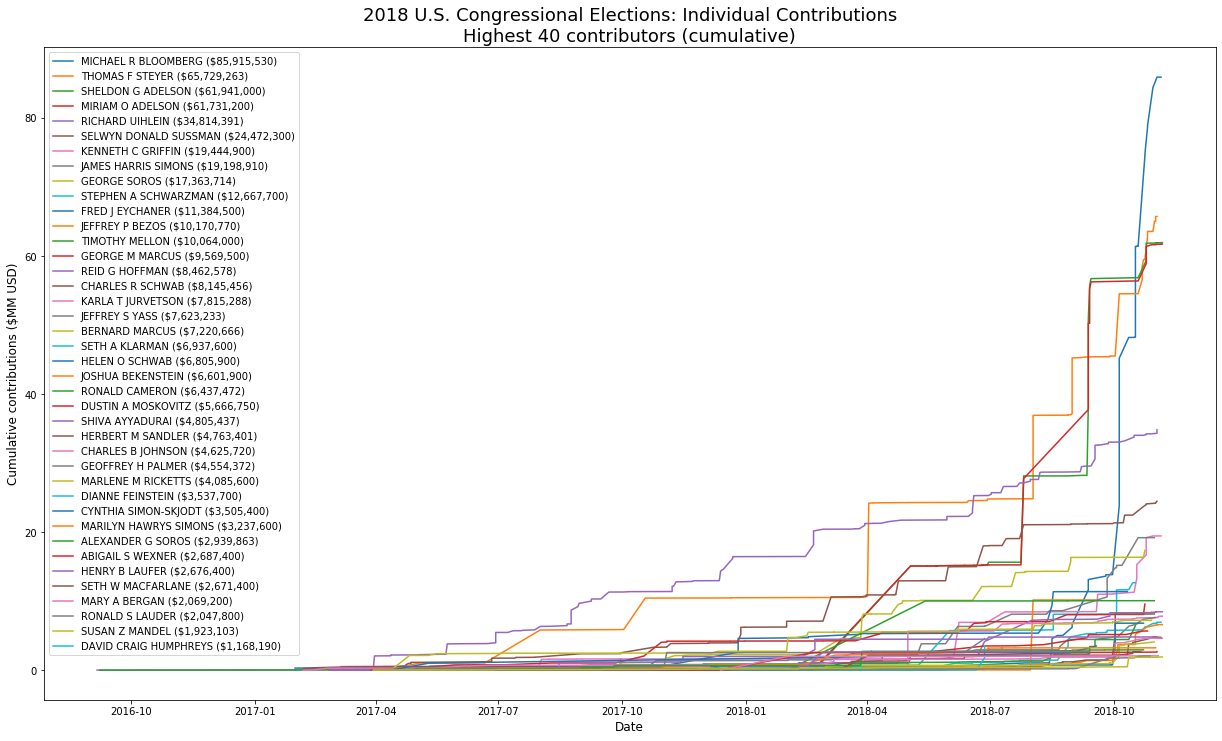

In [286]:
plt.figure(figsize = (21, 12))

for donor in high:
    lil_indiv = indiv[indiv['name'] == donor]
    lil_indiv.sort_values(['transaction_dt'], ascending = True, inplace = True)
    lil_indiv['cumsum'] = lil_indiv['transaction_amt'].cumsum()
    total = list(lil_indiv['cumsum'])[-1]
    plt.plot(
        lil_indiv['transaction_dt'],
        lil_indiv['cumsum']/1.0E6, 
        label = donor.replace(' 1', '') + ' (${:,})'.format(total),
    )

plt.title(
    '2018 U.S. Congressional Elections: Individual Contributions\nHighest 40 contributors (cumulative)', 
    fontsize = 18, 
)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Cumulative contributions ($MM USD)', fontsize = 12)
plt.legend(loc = 'best')
plt.show();

In [287]:
ccl_dict = dict(zip(ccl['cand_id'], ccl['cmte_id']))
ccl_redict = dict(zip(ccl['cmte_id'], ccl['cand_id']))

cand = pd.read_csv('data/02a_cand_clean.csv')
cmtes = list(ccl_dict.keys())
cand['cmte_id'] = [ccl_dict[x] if (x in cmtes) else np.nan for x in cand['cand_id']]
cand.head()

,cand_id,cand_name,cand_ici,cand_pty_affiliation,ttl_receipts,trans_from_auth,ttl_disb,trans_to_auth,coh_bop,coh_cop,...,pol_pty_contrib,cvg_end_dt,indiv_refunds,cmte_refunds,position,contest,type,state,cm_links,cmte_id
0,S8FL00273,"SCOTT, RICK GOV",C,Republican,85231716.47,1036189.15,83771112.48,0.0,0.0,1460603.73,...,5050.0,2018-12-01,185475.35,10000.0,S,FL_senate,Group 10,FL,3,C00689471
1,S8TX00285,"O'ROURKE, ROBERT (BETO)",C,Democrat,80344836.34,53666.26,80458720.11,0.0,398699.0,284815.77,...,500.0,2018-12-01,1264011.92,5117.0,S,TX_senate,Group 04,TX,2,C00501197
2,S8NJ00509,"HUGIN, ROBERT",C,Republican,39236111.14,26370.03,39113138.31,0.0,0.0,122972.96,...,0.0,2018-12-01,6995.00,1000.0,S,NJ_senate,Group 10,NJ,2,C00689471
3,S6MO00305,"MCCASKILL, CLAIRE",I,Democrat,37714657.65,2963215.80,38254849.68,200.0,781519.0,241328.55,...,0.0,2018-12-01,452202.29,12500.0,S,MO_senate,Group 02,MO,18,C00685057
4,S2TX00312,"CRUZ, RAFAEL EDWARD TED",I,Republican,35409076.68,4105176.86,39458809.82,124177.0,4207690.0,157958.64,...,100.0,2018-12-01,178714.00,6000.0,S,TX_senate,Group 04,TX,4,C00676676


In [288]:
indiv['cand_id'] = [ccl_redict[x] if x in list(ccl_redict.keys()) else np.nan for x in indiv['cmte_id']]
indiv['cand_id'].value_counts()[:10]

S8TX00285    278578
S6MO00305    148425
S2TX00312    144059
S2MA00170    127216
S2WI00219    111758
S6OH00163     95726
S8NV00156     85534
S8FL00166     83492
S6MT00162     56449
S2ND00099     55733
Name: cand_id, dtype: int64

In [289]:
indiv['transaction_tp'].value_counts()

15     8661297
24T    5208291
15E    4776021
22Y     209128
10      183840
24I      20947
15C      14352
11        3422
31        1779
20Y        558
32         518
30         181
21Y         67
31T         42
32T          6
30T          1
Name: transaction_tp, dtype: int64

In [290]:
indiv['transaction_dt'].sort_values()[:10]

9365936    2016-01-31
11417023   2016-02-08
5021893    2016-02-09
5021892    2016-02-09
1909934    2016-02-11
1909979    2016-02-11
714623     2016-02-17
714622     2016-02-17
714621     2016-02-17
714620     2016-02-17
Name: transaction_dt, dtype: datetime64[ns]

In [291]:
abbr_cand = pd.read_csv('../../assets/abbreviations.csv')
abbr_dict = dict(zip(abbr_cand['abbreviation'], abbr_cand['name']))

not_states = list(set(indiv['state']))

not_states = [x for x in not_states if x not in list(abbr_dict.keys())]
print(len(indiv[indiv['state'].apply(lambda x: x in not_states)]))
not_states

42321


['FM', 'AA', 'ZZ', 'PW', 'AP', 'MH', 'AE', 'nan']

In [292]:
len(indiv)

19080450

In [293]:
for which in not_states:
    lil_indiv = indiv.loc[indiv['state'] == which, ['city', 'zip_code']].drop_duplicates()
    print(which)
    print(lil_indiv)
    print('\n\n')

FM
                     city zip_code
3773781             MIAMI    33139
3773762       MIAMI BEACH    33139
3065158       MIAMI BEACH    33141
5798090      OAKLAND PARK    33307
17998432           DELAND    32724
9293960          ST CLOUD    34769
16995510      SPRING HILL    34609
18073716      BROOKSVILLE    34609
20754303           NAPLES    34105
16991945  SUN CITY CENTER    33573
16991942         LAKELAND    33813
16992074        RIVERVIEW    33578
20754819     WINTER HAVEN    33884
16982604         SURFSIDE    33154
9381834        PLANT CITY    33563



AA
                        city zip_code
1798682             BORDEAUX    33000
1804461                PARIS    75008
4906665                  DPO    34020
4950713            FUCHU-SHI    00000
5335644            MOONTREUX    01820
...                      ...      ...
20811746       VANCOUVER, BC    00000
8330328                  DPO    34041
21291014  STEINHEIM, GERMANY    00000
21439898     CALGARY, CANADA    00000
14392370     

In [294]:
won = pd.read_csv('data/winners_2018.csv')
winners = list(won['cand_id'])

In [303]:
cand['in-state'] = [np.nan]*len(cand)
cand['out-of-state'] = [np.nan]*len(cand)

contests = sorted(list(set(cand['contest'])))
contests = [x for x in contests if x != '00_00']

# plot settings per party
party_dict = {
    'Republican' : {
        'hex' : '#FF6661', 
        'party' : 'Republican',
    },
    'Democrat' : {
        'hex' : '#5494F7', 
        'party' : 'Democrat',
    },
    'Third party' : {
        'hex' : '#15DCDC',
        'party' : 'Third party',
    },
    'Democrat 2' : {
        'hex' : '#0A59D3',
        'party' : 'Democrat',        
    },  
    'Republican 2' : {
        'hex' : '#cd0600',
        'party' : 'Republican',
    },
    'Third party 2' : {
        'hex' : '#0C8080',
        'party' : 'Third party',
    },
    'Democrat 3' : {
        'hex' : '#063784',
        'party' : 'Democrat',
    },  
    'Republican 3' : {
        'hex' : '#750400',
        'party' : 'Republican',
    },
    'Third party 3' : {
        'hex' : '#074949',
        'party' : 'Third party',
    },
}

vol_light = '#f8fbfc'
vol_dark = '#263C4D'

def plot_indiv_contribs(contest):
    parties = []
    legend_elements = []
    lil_cand = cand[cand['contest'] == contest]
    lil_cand.sort_values(['cand_pty_affiliation'], ascending = True, inplace = True)
    candidates = list(lil_cand['cand_id'])
    candidates = [x for x in candidates if x in list(set(indiv['cand_id']))]
    if len(candidates) > 1:
        print(contest)
        print('\n')
        fig = plt.figure(figsize = (14, 8))
        fig.patch.set_facecolor(vol_light)
        ax = fig.add_subplot(111)
        ax.patch.set_facecolor(vol_light)

        vol_dark_rcparams = [
            'patch.edgecolor',
            'grid.color',
            'text.color',
            'axes.labelcolor',
            'xtick.color',
            'ytick.color',
            'axes.edgecolor'
        ]

        for which in vol_dark_rcparams:
            plt.rcParams[which] = vol_dark

        font_dirs = ['../../css/fonts/for_matplotlib/', ]
        font_files = fm.findSystemFonts(fontpaths=font_dirs)
        font_list = fm.createFontList(font_files)
        fm.fontManager.ttflist.extend(font_list)

        plt.rcParams['font.family'] = 'DM Sans Medium'
        
        getmax = []
        for candidate in candidates:
            if candidate in winners:
                mult = 2
                win = ' (winner)'
            else:
                mult = 1
                win = ''
            lil_indiv = indiv[indiv['cand_id'] == candidate].sort_values(['transaction_dt'])
            name = list(lil_cand.loc[lil_cand['cand_id'] == candidate, 
                                     'cand_name'].values)[0]
            party = list(lil_cand.loc[lil_cand['cand_id'] == candidate, 
                                      'cand_pty_affiliation'].values)[0]
            if party in parties:
                if f'{party} 2' in parties:
                    party = f'{party} 3'
                else:
                    party = f'{party} 2'
            parties.append(party)
            
            incumbent = (list(lil_cand.loc[lil_cand['cand_id'] == candidate, 
                                      'cand_ici'].values)[0] == 'I')
            
            if incumbent:
                inc = ' (incumbent)'
            else:
                inc = ''
            
            print(name)
            print('${:,}'.format(int(lil_indiv.loc[lil_indiv['entity_tp'] == 'CAN', 'transaction_amt'].sum())))
            print('\n')
            demo_indiv = lil_indiv.drop_duplicates(['name', 'occupation'])
            print('in-state employer/occupation freqs:')
            instate = demo_indiv[demo_indiv['state'] == contest.split('_')[0]]
            print(len(instate))
            print('\n')
            print(instate['employer'].value_counts()[:10])
            print('\n')
            print(instate['occupation'].value_counts()[:10])
            print('\n')
            print('out-of-state employer/occupation freqs:')
            outstate = demo_indiv[demo_indiv['state'] != contest.split('_')[0]]
            print(len(outstate))
            print('\n')
            print(outstate['employer'].value_counts()[:10])
            print('\n')
            print(outstate['occupation'].value_counts()[:10])
            print('\n')
                
            lil_row = []
            donors = list(set(lil_indiv['name']))
            for donor in donors:
                lil_donor = lil_indiv[(lil_indiv['name'] == donor) & (lil_indiv['entity_tp'] == 'IND')]

                if len(lil_donor) != 0:
                    pcc_mask = [True if x in pccs else False for x in lil_donor['cmte_id']]
                    
                    # primary campaign committee(S)
                    lil_pcc = lil_donor[pcc_mask]
                    lil_pcc_total = 0
                    pcc_cities = list()
                    pcc_states = list()
                    pcc_zips = list()
                    pcc_emps = list()
                    pcc_occs = list()
                    if len(lil_pcc) != 0:
                        pcc_cities = str(list(set(lil_pcc['city'])))
                        pcc_states = str(list(set(lil_pcc['state'])))
                        pcc_zips = str(list(set(lil_pcc['zip_code'])))
                        pcc_emps = str(list(set(lil_pcc['employer'])))
                        pcc_occs = str(list(set(lil_pcc['occupation'])))
                        lil_pcc_total = lil_pcc['transaction_amt'].sum()
                        
                    not_pcc_mask = [True if x not in pccs else False for x in lil_donor['cmte_id']]
                    
                    lil_notpcc = lil_donor[not_pcc_mask] 
                    lil_notpcc_total = 0
                    notpcc_cities = list()
                    notpcc_states = list()
                    notpcc_zips = list()
                    notpcc_emps = list()
                    notpcc_occs = list()
                    if len(lil_notpcc) != 0:
                        notpcc_cities = str(list(set(lil_notpcc['city'])))
                        notpcc_states = str(list(set(lil_notpcc['state'])))
                        notpcc_zips = str(list(set(lil_notpcc['zip_code'])))
                        notpcc_emps = str(list(set(lil_notpcc['employer'])))
                        notpcc_occs = str(list(set(lil_notpcc['occupation'])))
                        lil_notpcc_total = lil_notpcc['transaction_amt'].sum()
                        
                    # create the list to turn into dataframe row
                    lil_row.append((
                        donor, 
                        pcc_cities,
                        pcc_states,
                        pcc_zips,
                        pcc_emps,
                        pcc_occs,
                        len(lil_pcc), 
                        lil_pcc_total,

                        notpcc_cities,
                        notpcc_states,
                        notpcc_zips,
                        notpcc_emps,
                        notpcc_occs,
                        len(lil_notpcc), 
                        lil_notpcc_total, 
                    ))
                else:
                    lil_row.append((donor, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))
            row_df = pd.DataFrame(lil_row)
            row_df.columns = [
                'name', 
                
                'pcc_cities',
                'pcc_states',
                'pcc_zips',
                'pcc_emps',
                'pcc_occs',
                'pcc_count', 
                'pcc_total', 

                'notpcc_cities',
                'notpcc_states',
                'notpcc_zips',
                'notpcc_emps',
                'notpcc_occs',
                'notpcc_count', 
                'notpcc_total', 
            ]
            
            # pcc
            row_df.sort_values(['pcc_total'], ascending = False, inplace = True)
            row_df.reset_index(drop = True, inplace = True)
            print('principal campaign committee(s)')
            print(list(lil_pcc['cmte_nm'].value_counts().index))
            print('contribution count <= 5400:', len(row_df[row_df['pcc_total'] <= 5400]))
            print('\n')
            if len(row_df[row_df['pcc_total'] > 5400]) > 0:
                print((row_df.loc[row_df['pcc_total'] > 5400, [
                    'name', 
                    'pcc_cities',
                    'pcc_states',
                    'pcc_zips',
                    'pcc_emps',
                    'pcc_occs',
                    'pcc_count', 
                    'pcc_total', 
                ]][:40]).to_csv(None))
            print('\n')
            
            # non-pcc
            row_df.sort_values(['notpcc_total'], ascending = False, inplace = True)
            row_df.reset_index(drop = True, inplace = True)
            if len(row_df[row_df['notpcc_total'] > 0]) > 0:
                print('other committee(s)')
                print(list(lil_notpcc['cmte_nm'].value_counts().index))
                print('\n')
                print((row_df.loc[row_df['notpcc_total'] > 0, [
                    'name', 
                    'notpcc_cities',
                    'notpcc_states',
                    'not_pcc_zips',
                    'notpcc_emps',
                    'notpcc_occs',
                    'notpcc_count', 
                    'notpcc_total', 
                ]][:40]).to_csv(None))
            print('\n')
            
            print('----------------------------------------------')
          
            legend_elements.append(
                mpatches.Patch(
                    [0], 
                    [0], 
                    color = party_dict[party]['hex'], 
                    label = party[0] + inc + win + ' - ' + name,
                    alpha = 0.85,
                    )
            )
            lil_indiv['cumsum'] = lil_indiv['transaction_amt'].cumsum()
            getmax.append(list(lil_indiv['cumsum'].values)[-1:][0])
            plt.plot(
                lil_indiv['transaction_dt'],
                lil_indiv['cumsum']/1.0E6,
                color = party_dict[party]['hex'],
                alpha = 1.0,
                lw = mult*2.,
            )     
            
            if contest != '00_00':
                
                statelet = contest.split('_')[0]

                cand.loc[cand['cand_id'] == candidate, 'in-state'] = \
                lil_indiv.loc[lil_indiv['state'] == statelet, 'transaction_amt'].sum()

                cand.loc[cand['cand_id'] == candidate, 'out-of-state'] = \
                lil_indiv.loc[lil_indiv['state'] != statelet, 'transaction_amt'].sum()       
            
                plt.plot(
                    lil_indiv.loc[lil_indiv['state'] == statelet, 'transaction_dt'],
                    lil_indiv.loc[lil_indiv['state'] == statelet, 'transaction_amt'].cumsum()/1.0E6,
                    color = party_dict[party]['hex'],
                    alpha = 0.6,
                    lw = mult*2.,
                    ls = '--',
                )

                plt.plot(
                    lil_indiv.loc[lil_indiv['state'] != statelet, 'transaction_dt'],
                    lil_indiv.loc[lil_indiv['state'] != statelet, 'transaction_amt'].cumsum()/1.0E6,
                    color = party_dict[party]['hex'],
                    alpha = 0.6,
                    lw = mult*2.,
                    ls = ':',
                )
                
        if contest == '00_00':
            title = f'{year} Presidential Contest:\nIndividual Contributions'
        else:
            state = abbr_dict[contest.split('_')[0]]
            district = contest.split('_')[1]
            if district == 'senate':
                title = f'{year} U.S. Senate Elections:\nIndividual Contributions for {state} Contest'
            elif district != '00':
                district = district.lstrip('0')
                title = f'{year} U.S. House of Representatives Elections:\nIndividual Contributions for {state} District {district}'
            else:
                title = f'{year} U.S. House of Representatives Elections:\nIndividual Contributions in {state} At-Large District'
        
        # note in plot title if contest for an open seat
        if 'O' in list(cand.loc[cand['cand_id'].apply(lambda x: x in candidates), 'cand_ici'].values):
            openflag = ' (open seat)'
        else:
            openflag = ''
        plt.title(
            title + openflag, 
            fontsize = 18, 
        )
        plt.xlabel('Date', fontsize = 18)
        plt.xlim([dt.strptime('2017-01-01', '%Y-%m-%d'), 
                  dt.strptime('2018-11-30', '%Y-%m-%d')])
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))
        plt.xticks(fontsize = 14)
        plt.ylabel('Cumulative individual\ncontributions ($MM USD)', fontsize = 14)
        plt.yticks(fontsize = 14)

        
        plt.axvline(
            dt.strptime('2018-11-06', '%Y-%m-%d'), 
            alpha = 0.3,
            label = 'Election day',
            color = vol_dark,
            ls = '--',
            
        )
        fec_deadlines = [
            '2017-03-31',
            '2017-06-30',
            '2017-09-30',
            '2017-12-31',
            '2018-03-31',
            '2018-06-30',
            '2018-09-30',
            '2018-10-19', # pre-general
            '2018-11-28', # post-general
            '2018-12-31', # year-end
            
        ]
        for x in fec_deadlines:
            plt.axvline(
                dt.strptime(x, '%Y-%m-%d'), 
                color = vol_dark,
                alpha = 0.1,
                lw = 1.0,
                ls = '--',
                
            )    
            
        x = ax.annotate('Sources: Ballotpedia, FEC.gov', 
                        xy=(0.0, 0.0), 
                        xytext=(69.0, -28.0), 
                        ha='center', 
                        va='bottom', 
                        textcoords='axes pixels', 
                        xycoords='axes pixels', 
                       )
    
        legend_elements.append(
            Line2D(
                [0], 
                [0], 
                color = vol_dark, 
                label = 'in-state & out-of-state',
                lw = 2., 
                alpha = 0.6,
                )
            )
        legend_elements.append(
            Line2D(
                [0], 
                [0], 
                color = vol_dark, 
                label = 'only in-state',
                ls = '--',
                lw = 2., 
                alpha = 0.6,
                )
            )
        legend_elements.append(
            Line2D(
                [0], 
                [0], 
                color = vol_dark, 
                label = 'only out-of-state',
                ls = ':',
                lw = 2., 
                alpha = 0.6,
                )
            )
        legend_elements.append(
                mpatches.Patch(
                    [0], 
                    [0], 
                    color = vol_light, 
                    label = 'NOTE: winner in bold',
                    )
                )
            
        legend = plt.legend(
            loc='upper left', 
            fontsize=12, 
            facecolor='#f8fbfc', 
            handles=legend_elements,
            handlelength=3.25,
        )
        # logo
        arr_img = plt.imread('../../assets/VOL_Logo_Color_Light_Green.png')
        imagebox = OffsetImage(arr_img, zoom=0.07)
        imagebox.image.axes = ax
        xy = (0.0, -45.0)
        ab = AnnotationBbox(imagebox, 
                            xy,
                            xybox=(xy[0], xy[1]),
                            xycoords='axes pixels',
                            boxcoords=('axes pixels'),
                            box_alignment=(0., 0.),
                            frameon=False,
                           )
        ax.add_artist(ab)
        plt.tight_layout()

        plt.show();
        
        print('\n\n\n')
    return

KY_06


MCGRATH, AMY
$3,572


in-state employer/occupation freqs:
2389


RETIRED                     508
SELF-EMPLOYED               170
NOT EMPLOYED                157
UNIVERSITY OF KENTUCKY      101
SELF                         93
NONE                         56
UK                           12
UNIVERSITY OF LOUISVILLE     11
SELF EMPLOYED                10
BAPTIST HEALTH                8
Name: employer, dtype: int64


RETIRED         535
NOT EMPLOYED    464
ATTORNEY        158
PHYSICIAN        82
PROFESSOR        60
LAWYER           23
ENGINEER         21
CONSULTANT       20
TEACHER          20
FARMER           18
Name: occupation, dtype: int64


out-of-state employer/occupation freqs:
4253


NOT EMPLOYED                             619
SELF                                     312
SELF-EMPLOYED                            287
RETIRED                                  179
NONE                                     139
GOOGLE                                    31
SELF EMPLOYED             

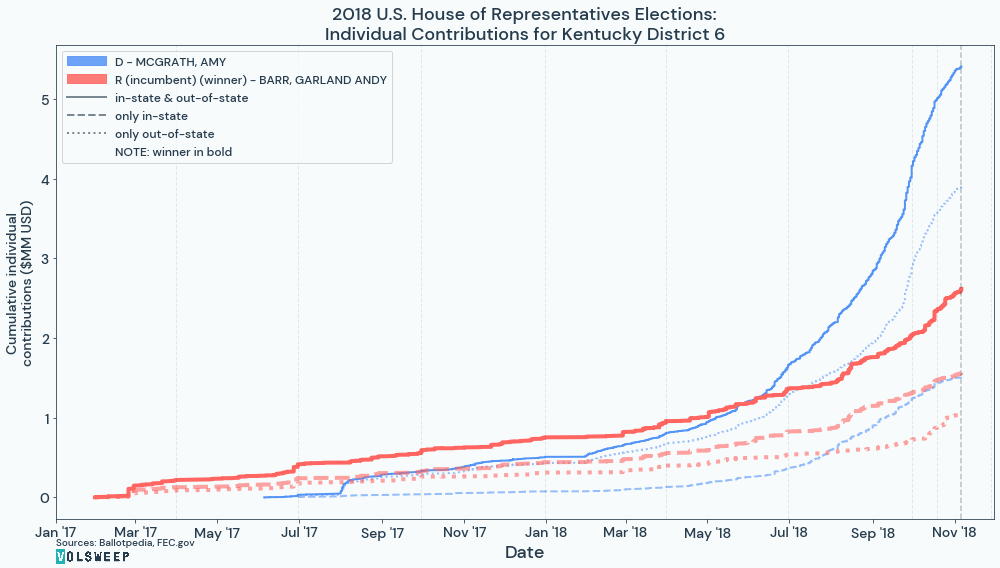





TX_23


JONES, GINA ORTIZ
$300


in-state employer/occupation freqs:
706


SELF-EMPLOYED           85
RETIRED                 27
SELF EMPLOYED           13
SELF                    13
NOT EMPLOYED             8
UNIVERSITY OF TEXAS      6
NONE                     3
JONES DAY                3
TEXAS STATE AQUARIUM     2
DOD                      2
Name: employer, dtype: int64


NOT EMPLOYED    164
ATTORNEY         73
RETIRED          73
SELF             22
LAWYER           18
PROFESSOR        17
PHYSICIAN        17
INVESTOR         13
CEO              10
CONSULTANT       10
Name: occupation, dtype: int64


out-of-state employer/occupation freqs:
2676


SELF-EMPLOYED          351
RETIRED                 42
SELF                    34
NOT EMPLOYED            25
GOOGLE                  21
SELF EMPLOYED           17
STANFORD UNIVERSITY     11
NONE                     9
HARVARD UNIVERSITY       8
UCSF                     7
Name: employer, dtype: int64


NOT EMPLOYED    642
RETIRED         252

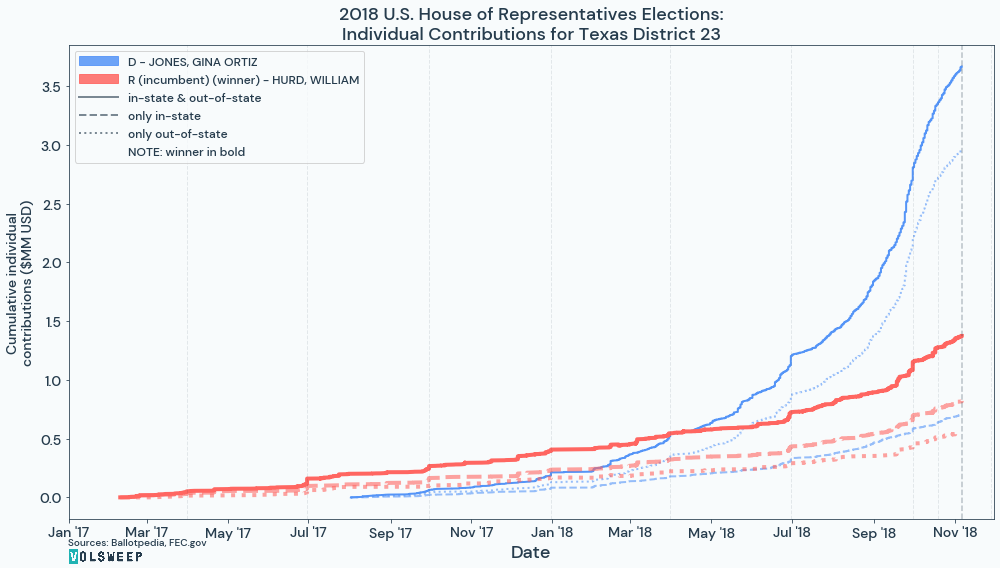





NY_01


GERSHON, PERRY
$1,699,411


in-state employer/occupation freqs:
1686


NOT EMPLOYED                     438
SELF EMPLOYED                    207
SELF-EMPLOYED                     24
RETIRED                           21
NONE                              20
STONY BROOK UNIVERSITY            20
RENAISSANCE TECHNOLOGIES, LLC     13
COLUMBIA UNIVERSITY               10
DEBEVOISE & PLIMPTON, LLP          9
CUNY                               6
Name: employer, dtype: int64


RETIRED         249
NOT EMPLOYED    229
ATTORNEY        180
PROFESSOR        46
PHYSICIAN        40
REAL ESTATE      39
FINANCE          30
EXECUTIVE        30
INVESTOR         22
HOMEMAKER        22
Name: occupation, dtype: int64


out-of-state employer/occupation freqs:
386


NOT EMPLOYED                         53
SELF EMPLOYED                        22
SELF-EMPLOYED                        13
DIVCOWEST                             7
LOANCORE CAPITAL                      7
RETIRED                              

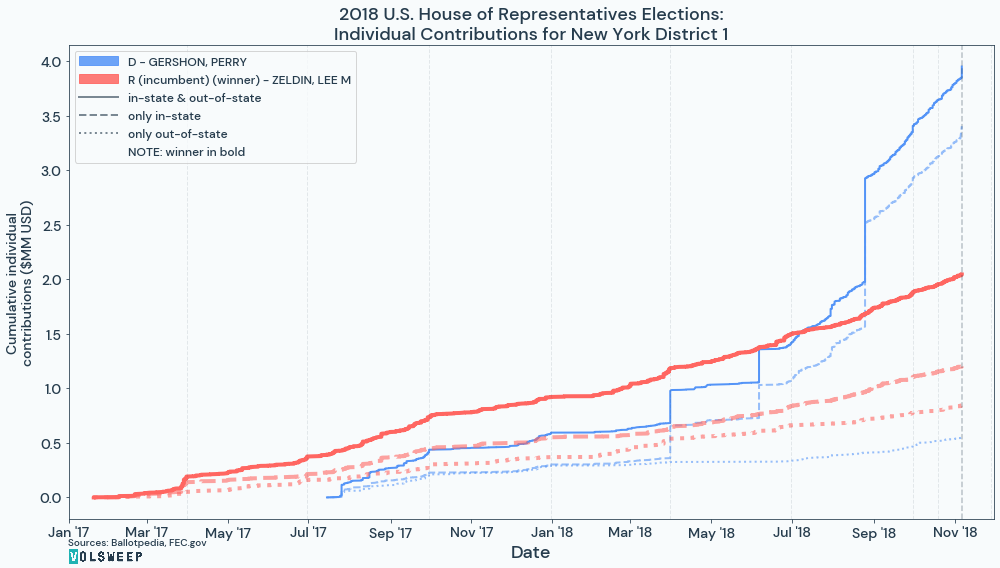





IL_13


LONDRIGAN, BETSY DIRKSEN
$15,000


in-state employer/occupation freqs:
1647


NOT EMPLOYED              260
RETIRED                   161
SELF                      104
NONE                       73
UNIVERSITY OF ILLINOIS     51
SELF EMPLOYED              27
STATE OF ILLINOIS          22
SELF-EMPLOYED              15
UIUC                       13
SIU SCHOOL OF MEDICINE     12
Name: employer, dtype: int64


NOT EMPLOYED    262
RETIRED         242
ATTORNEY        222
PROFESSOR        56
PHYSICIAN        47
CONSULTANT       43
LAWYER           41
NONE             28
CEO              23
PRESIDENT        20
Name: occupation, dtype: int64


out-of-state employer/occupation freqs:
1121


NOT EMPLOYED      239
SELF              117
NONE               96
RETIRED            38
SELF EMPLOYED      23
SELF-EMPLOYED      19
NOT-EMPLOYED        8
BAIN & COMPANY      6
MRHFM               5
DLA PIPER           4
Name: employer, dtype: int64


NOT EMPLOYED    239
ATTORNEY        104
RETIRED 

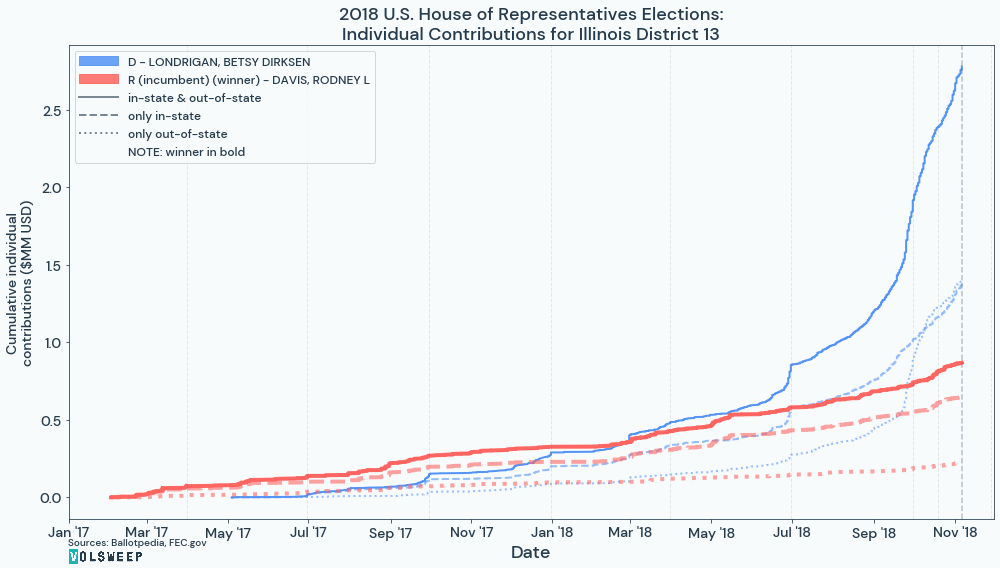





PA_01


WALLACE, HENRY SCOTT
$22,892


in-state employer/occupation freqs:
322


NOT EMPLOYED                         115
SELF EMPLOYED                         32
UNIVERSITY OF PENNSYLVANIA             5
NONE                                   4
SELF-EMPLOYED                          2
PENN STATE UNIVERSITY                  2
BUCHANAN, INGERSOLL, & ROONEY, PC      2
JOHNSON & JOHNSON                      2
RIDER UNIVERSITY                       2
MERCK                                  2
Name: employer, dtype: int64


RETIRED                    92
ATTORNEY                   38
NOT EMPLOYED               23
PHYSICIAN                  10
PROFESSOR                  10
ENGINEER                    6
OWNER                       5
MANAGER                     5
CHIEF EXECUTIVE OFFICER     5
PRESIDENT                   4
Name: occupation, dtype: int64


out-of-state employer/occupation freqs:
587


NOT EMPLOYED              157
SELF EMPLOYED              92
NONE                        6
GOOGL

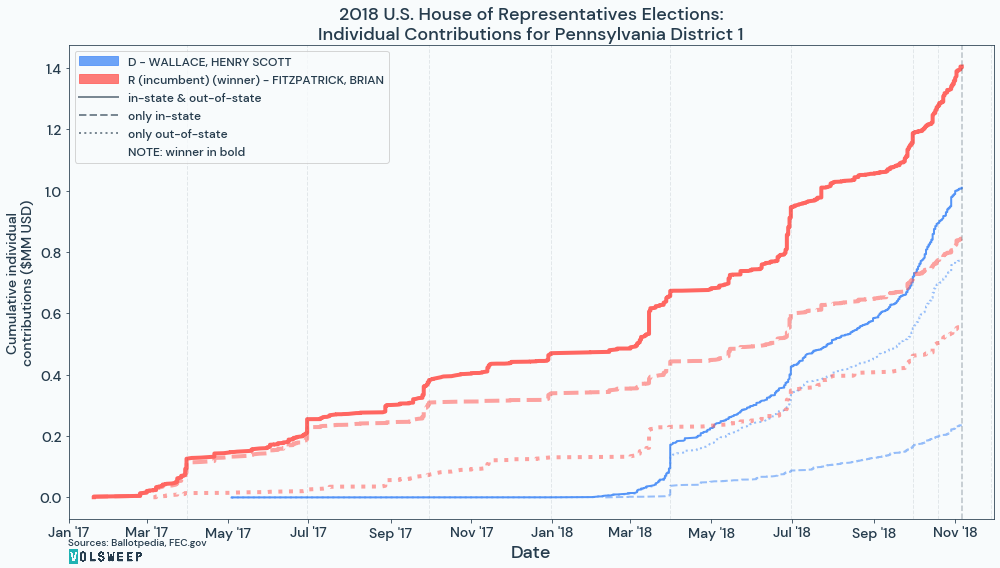





IN_02


HALL, MEL
$22,000


in-state employer/occupation freqs:
516


NONE                        40
UNIVERSITY OF NOTRE DAME    25
RETIRED                     24
SELF-EMPLOYED               12
SELF EMPLOYED                7
NOTRE DAME                   6
CITY OF SOUTH BEND           6
PRESS GANEY                  5
SELF                         5
BEACON MEDICAL GROUP         4
Name: employer, dtype: int64


RETIRED         65
ATTORNEY        62
NOT EMPLOYED    42
PHYSICIAN       17
PROFESSOR       15
OWNER           13
PRESIDENT       10
HOMEMAKER        9
CONSULTANT       6
PARTNER          6
Name: occupation, dtype: int64


out-of-state employer/occupation freqs:
165


NONE                       10
SPECIALTYCARE               7
RETIRED                     5
THE CHARTIS GROUP           5
SELF-EMPLOYED               5
AMERICAN SECURITIES LLC     4
AMERICAN SECURITIES         4
MEDSTAR HEALTH              3
PRESS GANEY ASSOCIATES      3
NOT EMPLOYED                2
Name: employer, 

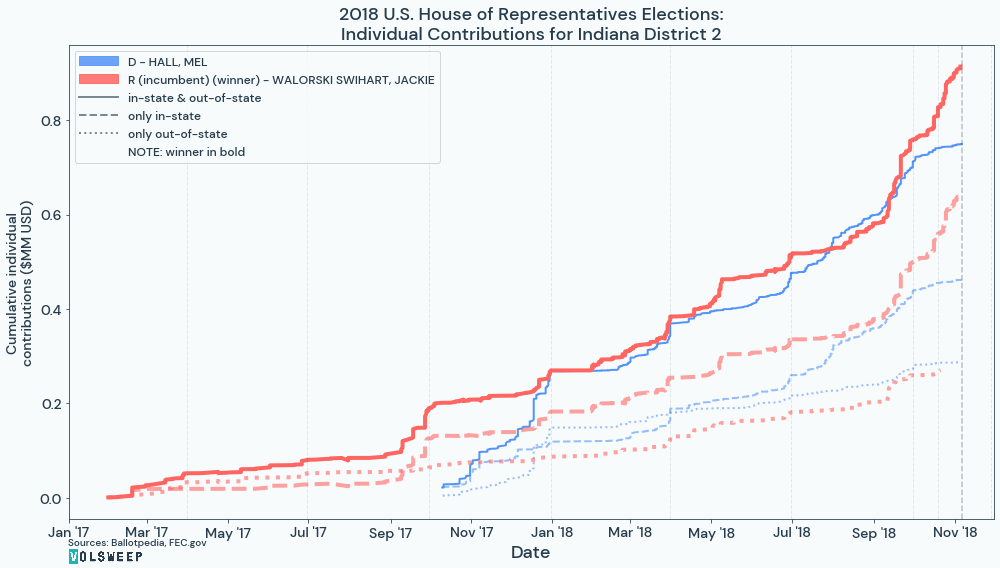





IL_12


KELLY, BRENDAN
$3,514


in-state employer/occupation freqs:
1391


NOT EMPLOYED            156
SELF                     64
RETIRED                  43
SELF-EMPLOYED            35
ST. CLAIR COUNTY         29
STATE OF ILLINOIS        24
ST CLAIR COUNTY          10
SELF EMPLOYED             9
NONE                      8
SIMMONS HANLY CONROY      7
Name: employer, dtype: int64


ATTORNEY        430
NOT EMPLOYED    187
RETIRED          93
LAWYER           53
PRESIDENT        27
OWNER            26
CONSULTANT       22
PROFESSOR        22
HOMEMAKER        14
JUDGE            12
Name: occupation, dtype: int64


out-of-state employer/occupation freqs:
1134


NOT EMPLOYED          218
SELF                  107
RETIRED                51
SELF-EMPLOYED          25
SELF EMPLOYED           8
GOOGLE                  6
HARVARD UNIVERSITY      5
THOMPSON COBURN         5
FACEBOOK                3
BOSTON UNIVERSITY       3
Name: employer, dtype: int64


NOT EMPLOYED    230
ATTORNEY        160

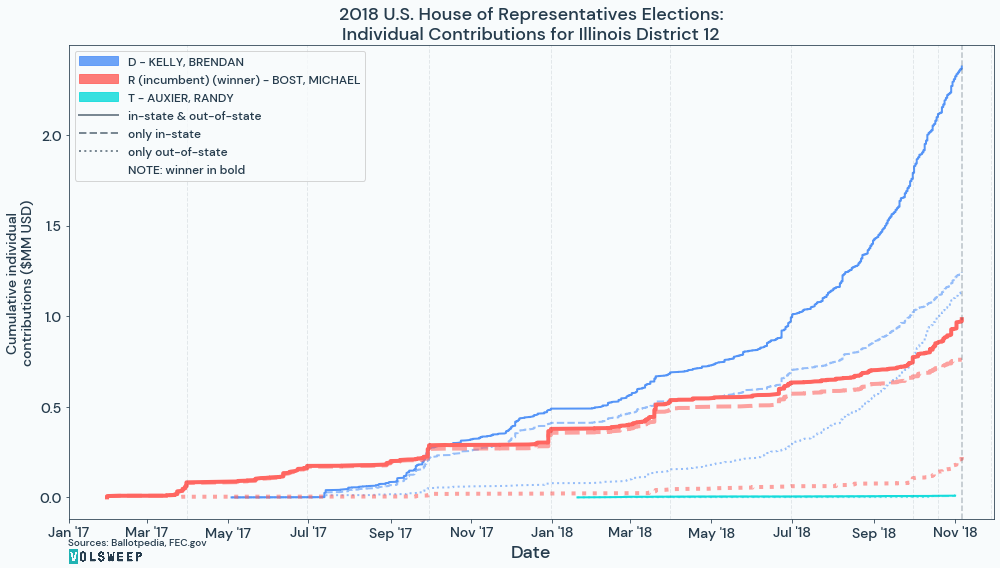





WA_03


LONG, CAROLYN N.
$2,896


in-state employer/occupation freqs:
2422


NOT EMPLOYED                   1202
SELF EMPLOYED                   221
NONE                             22
MICROSOFT                        21
UNIVERSITY OF WASHINGTON         20
SELF                             16
WASHINGTON STATE UNIVERSITY      11
STATE OF WASHINGTON               9
LOWER COLUMBIA COLLEGE            7
RETIRED                           6
Name: employer, dtype: int64


NOT EMPLOYED         988
RETIRED              217
ATTORNEY             150
PHYSICIAN             59
CONSULTANT            57
OWNER                 31
PROFESSOR             30
MANAGER               30
ENGINEER              27
SOFTWARE ENGINEER     26
Name: occupation, dtype: int64


out-of-state employer/occupation freqs:
708


NOT EMPLOYED                          233
SELF EMPLOYED                         106
NONE                                    4
SELF                                    4
OHSU                           

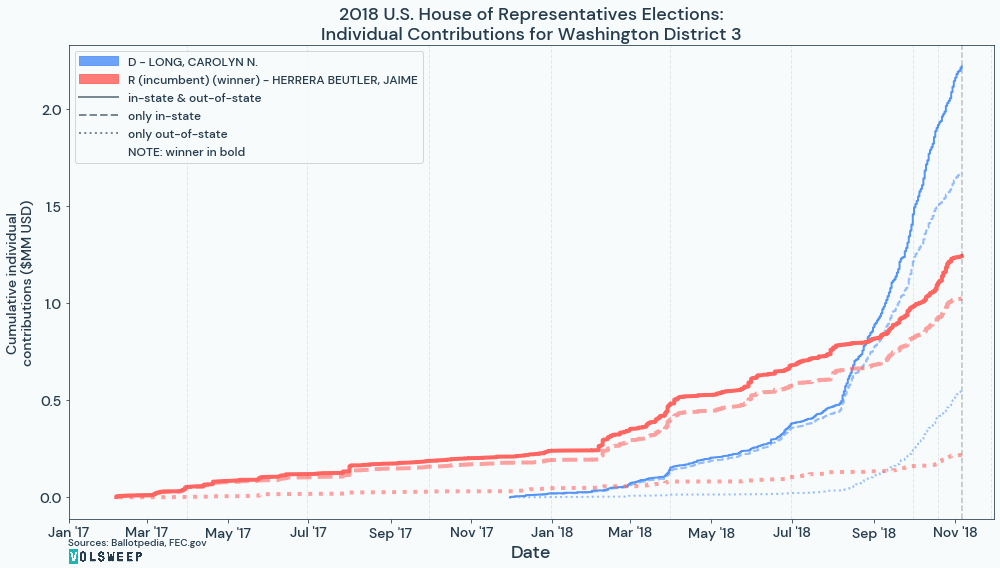





NE_02


EASTMAN, KARA
$4,745


in-state employer/occupation freqs:
652


NOT EMPLOYED              102
RETIRED                    51
SELF                       51
NONE                       27
UNMC                       15
CREIGHTON UNIVERSITY       12
SELF-EMPLOYED              10
UNO                         6
SELF EMPLOYED               5
UNIVERSITY OF NEBRASKA      5
Name: employer, dtype: int64


NOT EMPLOYED          102
ATTORNEY               40
RETIRED                36
PROFESSOR              22
OWNER                  19
PHYSICIAN              19
LAWYER                 18
EXECUTIVE DIRECTOR     10
TEACHER                10
CONSULTANT              9
Name: occupation, dtype: int64


out-of-state employer/occupation freqs:
925


NOT EMPLOYED           186
SELF                   108
NONE                    64
RETIRED                 49
SELF-EMPLOYED           18
GOOGLE                   7
VERTICAL WEB MEDIA       6
STANFORD UNIVERSITY      5
SELF EMPLOYED            5
STANFORD  

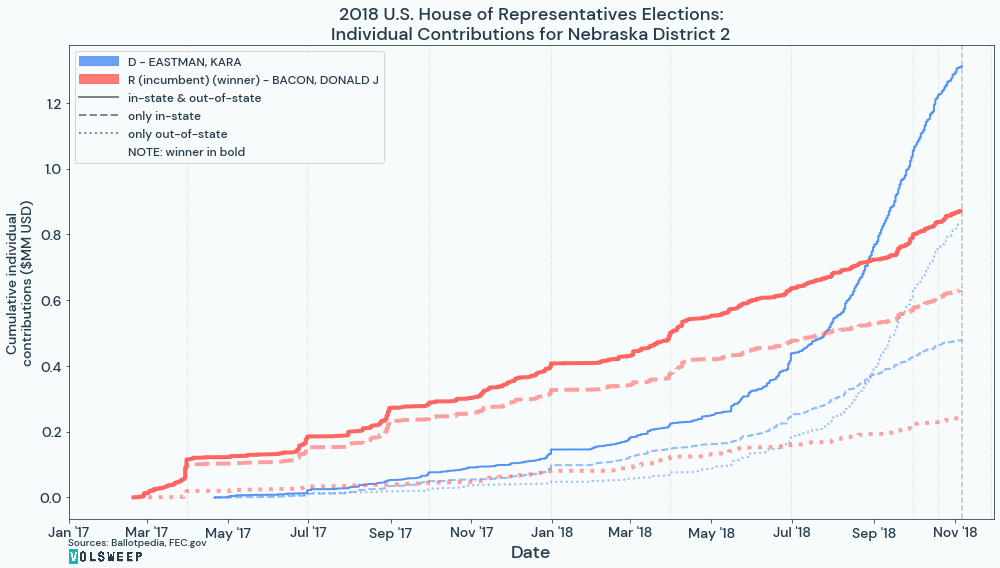





OH_12


O'CONNOR, DANIEL JAY
$0


in-state employer/occupation freqs:
1057


NOT EMPLOYED                 275
RETIRED                       73
SELF                          69
NONE                          63
OHIO STATE UNIVERSITY         16
THE OHIO STATE UNIVERSITY     11
SELF-EMPLOYED                  7
SELF EMPLOYED                  4
DENISON UNIVERSITY             4
CITY OF COLUMBUS               4
Name: employer, dtype: int64


NOT EMPLOYED    290
RETIRED          92
ATTORNEY         79
PHYSICIAN        25
NONE             24
PROFESSOR        22
CONSULTANT       16
PARTNER          12
TEACHER          10
ENGINEER         10
Name: occupation, dtype: int64


out-of-state employer/occupation freqs:
4315


NOT EMPLOYED                1407
SELF                         507
NONE                         430
RETIRED                      229
SELF-EMPLOYED                 50
SELF EMPLOYED                 36
GOOGLE                        11
STANFORD UNIVERSITY            7
MICROSOFT     

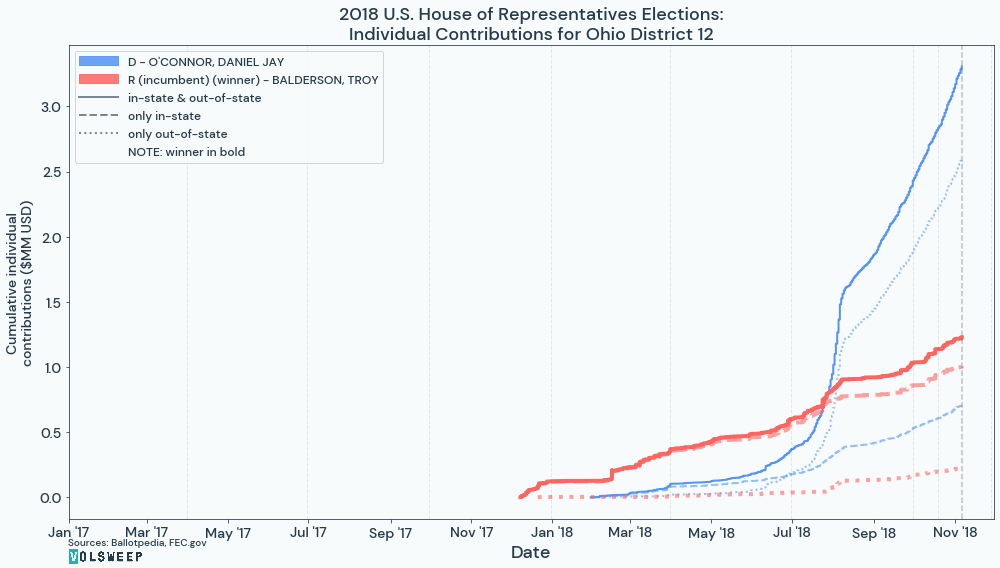

In [306]:
for which in ['KY_06', 'TX_23', 'NY_01', 'IL_13', 'PA_01', 'IN_02', 'IL_12', 'WA_03', 'NE_02', 'OH_12']:
    plot_indiv_contribs(which)

In [ ]:
plt.figure()

bigs = list(indiv['name'].value_counts().index)[:90]

for big in bigs:
    lil_indiv = indiv[indiv['name'] == big]
    print(big.replace(' 1', ''))
    print(lil_indiv['transaction_amt'].sum())
    most = list(lil_indiv['cmte_id'].value_counts().index)
    most = [cm_dict[x] for x in most if x in list(cm_dict.keys())]
    print(most[:5], '\n')
    lil_indiv.sort_values(['transaction_dt'], ascending = True, inplace = True)
    lil_indiv['cumsum'] = lil_indiv['transaction_amt'].cumsum()
    plt.plot(
        lil_indiv['transaction_dt'],
        lil_indiv['cumsum'],
    )
    
plt.show();

In [ ]:
# # big_indiv = []
# types = [x for x in list(set(indiv['entity_tp'])) if x != 'IND']

# lilling_indiv = deepcopy(indiv)

# for tp in types:
#     print(tp)
#     lil_tp = lilling_indiv[lilling_indiv['entity_tp'] == tp]
#     names = list(lil_tp['name'].value_counts().index)
#     for name in names:
#         lil_ind = lil_tp[lil_tp['name'] == name]
#         row = (
#             name, 
#             tp, 
#             len(lil_ind), 
#             len(set(lil_ind['cmte_id'])),
#             lil_ind['transaction_amt'].sum(), 
#             round(lil_ind['transaction_amt'].mean(), 2),
#             lil_ind['transaction_amt'].median(),
#             lil_ind['transaction_amt'].max(),
            
#         )
#         big_indiv.append(row)
#         lilling_indiv = lilling_indiv[lilling_indiv['entity_tp'] != tp]
        
big_df = pd.DataFrame(
    big_indiv,
    columns = [
        'name',
        'entity_tp',
        'count',
        'distinct_count',
        'total_amount',
        'mean_amount',
        'median_amount',
        'max_amount',
        
    ], 
    index = range(len(big_indiv)),
    
)

big_df

In [ ]:
fig, axes = plt.subplots(1, 6, figsize = (18, 6))

tps = list(set(big_df['entity_tp']))
for i in range(len(tps)):
    lil_df = big_df[big_df['entity_tp'] == tps[i]]
    axes[i].scatter(
        lil_df['distinct_count'],
        lil_df['total_amount']/1.0E6,
        s = 20,
    )
    axes[i].set_ylim([-1, 1.1*big_df['total_amount'].max()/1.0E6])
    axes[i].set_title(tps[i])
    
plt.show();

In [ ]:
big_df[(big_df['entity_tp'] == 'CAN') & (big_df['distinct_count'] > 1)]

In [ ]:
plt.figure(figsize = (21, 3))

plt.scatter(
    big_df.loc[big_df['entity_tp'] == 'IND', 'distinct_count'],
    big_df.loc[big_df['entity_tp'] == 'IND', 'total_amount']/1.0E6, 
    s = 20,
)

plt.xlabel('Distinct contributions', fontsize = 14)
plt.ylabel('Total contributions', fontsize = 14)
plt.show();

In [ ]:
for tp in list(set(big_df['entity_tp'])):
    print(tp)
    plt.figure(figsize = (21, 3))
    
    lil_df = big_df[big_df['entity_tp'] == tp]

    plt.scatter(
        lil_df['distinct_count'],
        lil_df['total_amount']/1.0E6,
    )

    plt.xlabel('Distinct Count')
    plt.xticks(range(0, lil_df['distinct_count'].max() + 1))
    plt.ylabel('Total Amount ($MM)')
    plt.show();

In [ ]:
indiv.to_csv('data/05a_indiv_contrib.csv', index = False)

In [ ]:
big_df.to_csv('data/05a_indiv_by_entitytp.csv', index = False)